In [ ]:
import numpy as np
import pandas as pd
import tqdm
import calflops
import seaborn as sns
import matplotlib.pyplot as plt
import wandb

import torch
import snntorch as snn

from config import (INP_SHAPE, CLASS_ENC, CLASS_DEC, 
                    BATCH_SIZE, DEVICE, SURROGATE_FN)
from plot_utils import set_plot_style, plot_curves, raster_plot
from data_setup import (load_datasets, get_dataloaders,
                        describe_data, get_dataloaders_delta)
from models import AE, SNN_CLSFF
import network
from train_eval import Trainer, CNNTrainer
from utils_fn import load_model, inference_time

torch.manual_seed(22)

set_plot_style() 

%reload_ext autoreload
%autoreload 2

### Load train, valid and test sets and create Dataloaders

In [ ]:
# Load datasets
train_dataset, val_dataset, test_dataset = load_datasets()

# Create dataloaders
train_loader, val_loader, test_loader = get_dataloaders(train_dataset, val_dataset, test_dataset, batch_size=8)

describe_data(train_loader, train_dataset, val_dataset, test_dataset)

Using cuda device

Shape of each element in the dataloader: torch.Size([8, 2, 232, 10, 64])
Number of elements in train - valid - test set: 1680 - 138 - 182


#### Plot some examples

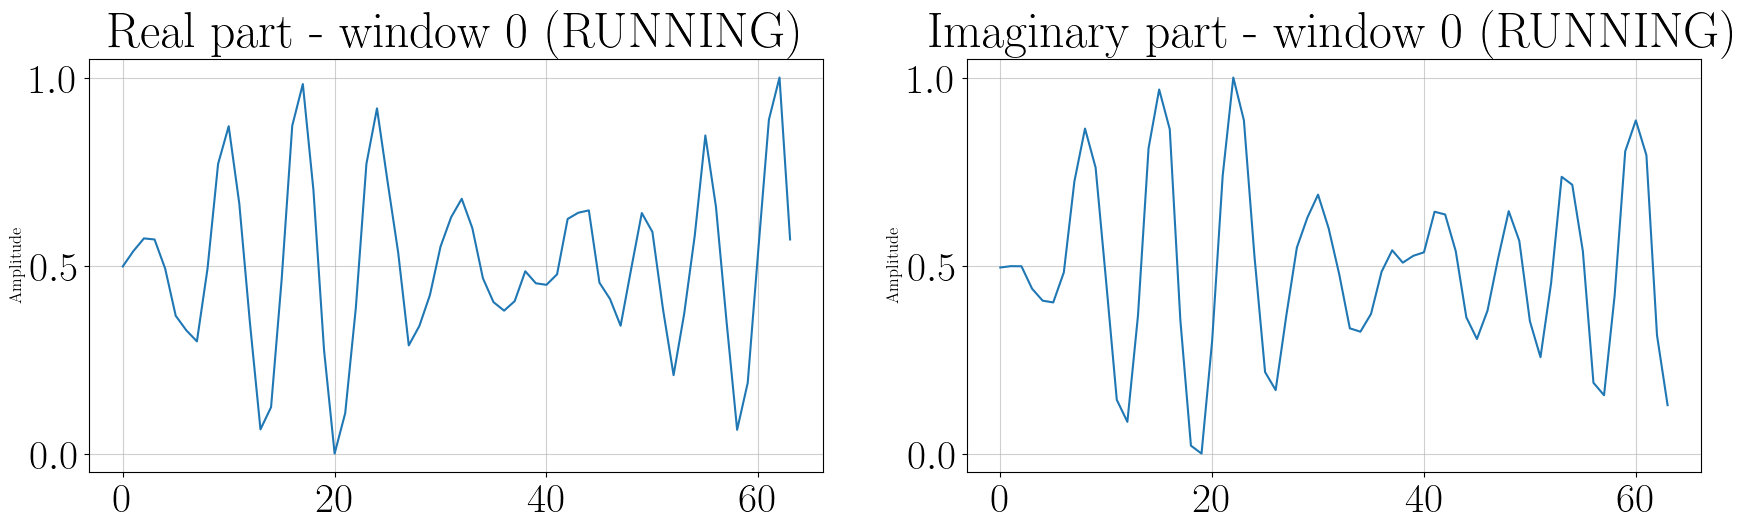

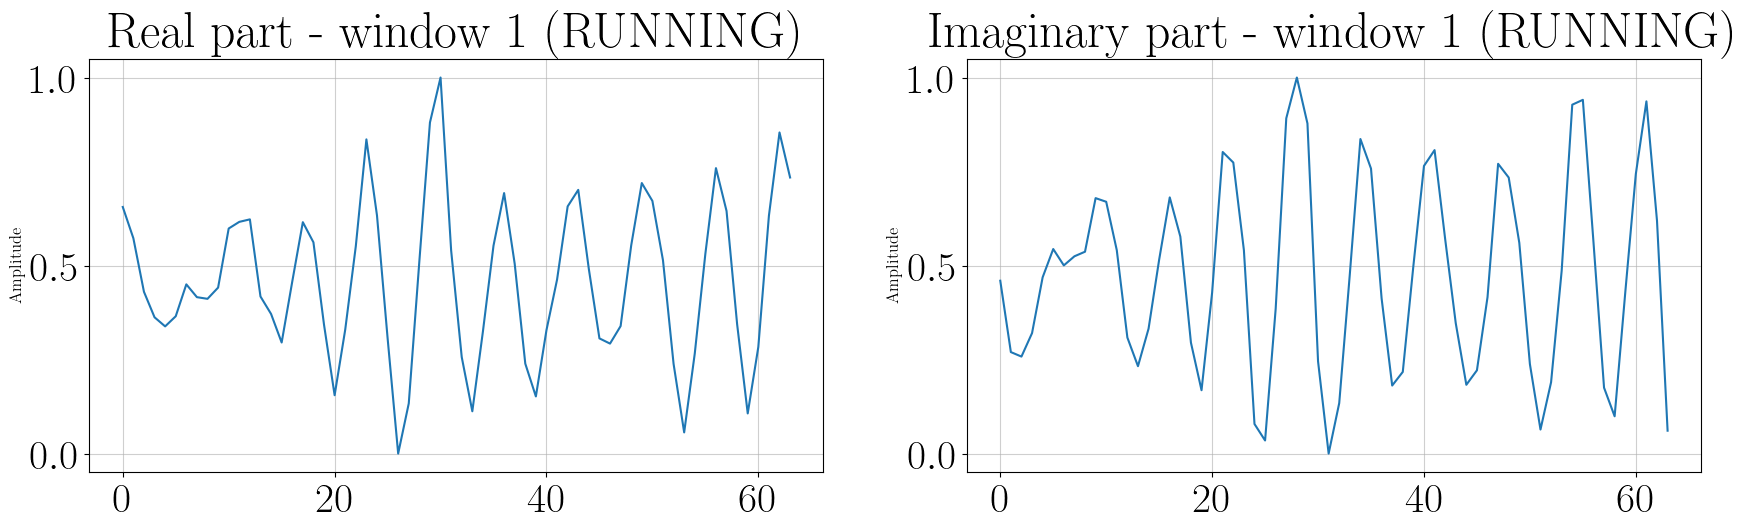

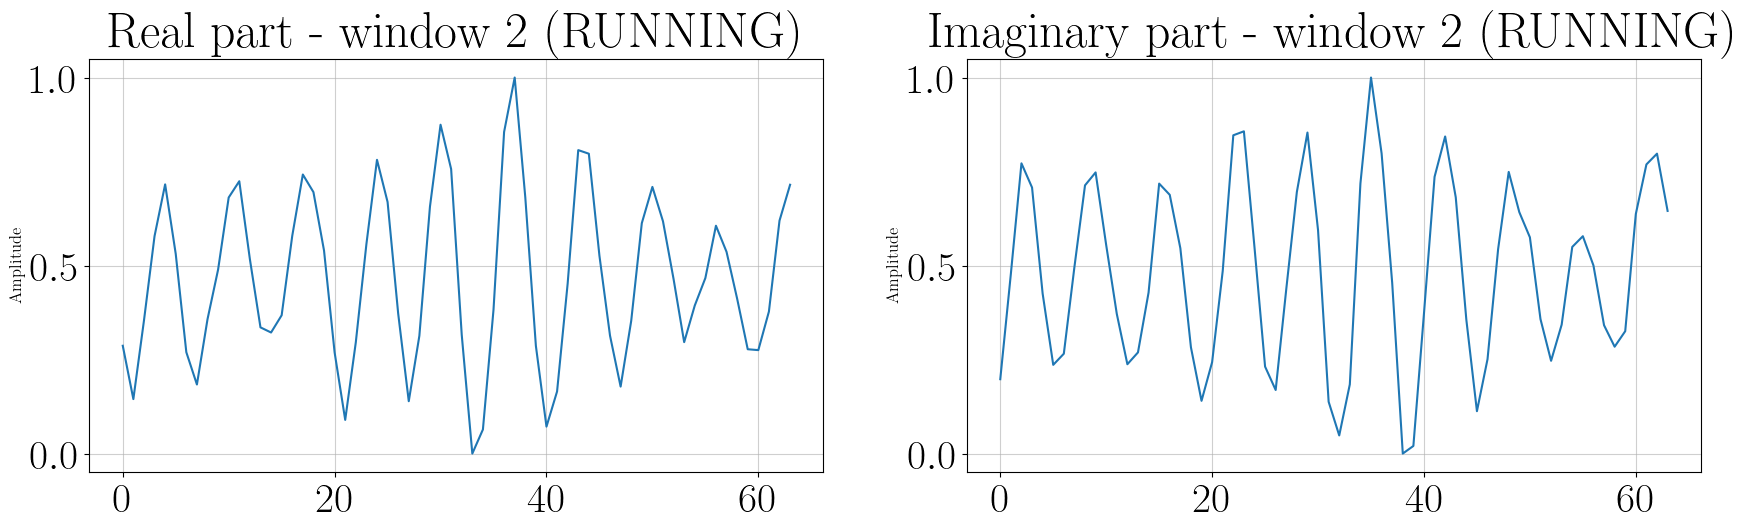

In [21]:
i = np.random.randint(0, len(train_dataset))
X, Y = train_dataset[i][0],train_dataset[i][-1]

for w in range(3):
    fig, ax = plt.subplots(1, 2, figsize=(18,6))

    plt.subplot(121)
    plt.plot(X[0, w, 0,:].cpu().numpy())
    plt.ylabel('Amplitude', fontsize=12)
    plt.title(f"Real part - window {w} ({CLASS_DEC[int(Y)]})")
    plt.grid()

    plt.subplot(122)
    plt.plot(X[1, w, 0,:].cpu().numpy())
    plt.ylabel('Amplitude',  fontsize=12)
    plt.title(f"Imaginary part - window {w} ({CLASS_DEC[int(Y)]})")
    plt.grid()
    plt.tight_layout()

    #plt.savefig('Signal_example1.png')
    plt.show()

#### Optimize $\tau$ parameter of the CAE

Values in $[0.1, 0.9]$ with a step size of 0.1. For each value of $\tau$ we made 5 different runs, to compute average and std of sparsity of the encoding and accuracy of classification in the validation set.

In [ ]:
tau_values = np.arange(0.6, 1.0, 0.1)

csv_path = "Tau_vs_accuracy_sparsity.csv"

try:
    df = pd.read_csv(csv_path)
except FileNotFoundError:
    df = pd.DataFrame(columns=["Tau", 
                               "Sparsity_avg", "Sparsity_std", 
                               "Accuracy_avg", "Accuracy_std"])
    
for tau in tau_values:
    print("###############")
    print(f"# Tau = {tau:.1f}")
    print("###############")

    sparsity_ls, accuracy_ls = [], []

    # repeat 5 runs with different initialization
    for run in range(5):
        print(f"  >> Run {run+1}/5")
        torch.cuda.empty_cache()

        autoencoder = network.cae_2(tau = tau,
                                    channels = 64, 
                                    kernel_size = (1,1,3), 
                                    stride = 1
                                    )

        snn = network.snn_1(input_shape = INP_SHAPE, 
                            hidden = [64,128], 
                            timesteps = 29,
                            kernel = (1,1,4),
                            stride = (1,2,2),
                            beta = 0.9,
                            threshold = 0.8,
                            learn_thr = True, 
                            learn_beta = True,
                            surr_grad = SURROGATE_FN
                            )

        net = AE(autoencoder, snn).to(DEVICE) 
        optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

        trainer = Trainer(
            model = net,
            optimizer = optimizer,
            device = DEVICE,
            acc_steps = 1,
            patience = 15,
            model_path = None
        )

        trainer.fit(
            train_loader = train_loader,
            val_loader = val_loader,
            epochs = 50
        )

        _, accuracy, sparsity = trainer.evaluate(val_loader)

        sparsity_ls.append(sparsity)
        accuracy_ls.append(accuracy)

    # log results
    new_row = pd.DataFrame([{
        "Tau": tau, 
        "Sparsity_avg": np.mean(sparsity_ls), 
        "Sparsity_std": np.std(sparsity_ls),
        "Accuracy_avg": np.mean(accuracy_ls),
        "Accuracy_std": np.std(accuracy_ls)
    }])

    df = pd.concat([df, new_row], ignore_index=True)
    df.to_csv(csv_path, index=False)    

###############
# Tau = 0.6
###############
  >> Run 1/5
Epoch 1 - train_loss: 0.6187 | train_acc: 0.7762 | val_loss: 0.4536 | val_acc: 0.7778
Epoch 6 - train_loss: 0.1009 | train_acc: 0.9792 | val_loss: 0.4285 | val_acc: 0.8681
Epoch 11 - train_loss: 0.0489 | train_acc: 0.9935 | val_loss: 0.7858 | val_acc: 0.8542
Epoch 16 - train_loss: 0.0452 | train_acc: 0.9929 | val_loss: 0.5677 | val_acc: 0.8819
Epoch 21 - train_loss: 0.0303 | train_acc: 0.9976 | val_loss: 0.4990 | val_acc: 0.9236
Epoch 26 - train_loss: 0.0382 | train_acc: 0.9940 | val_loss: 0.7501 | val_acc: 0.8681
Epoch 31 - train_loss: 0.0393 | train_acc: 0.9964 | val_loss: 0.7722 | val_acc: 0.8889
Early stopping at epoch 35
  >> Run 2/5
Epoch 1 - train_loss: 0.5791 | train_acc: 0.7738 | val_loss: 0.3665 | val_acc: 0.8403
Epoch 6 - train_loss: 0.1036 | train_acc: 0.9780 | val_loss: 0.5743 | val_acc: 0.7917
Epoch 11 - train_loss: 0.0768 | train_acc: 0.9833 | val_loss: 0.4379 | val_acc: 0.8681
Epoch 16 - train_loss: 0.0411 | train

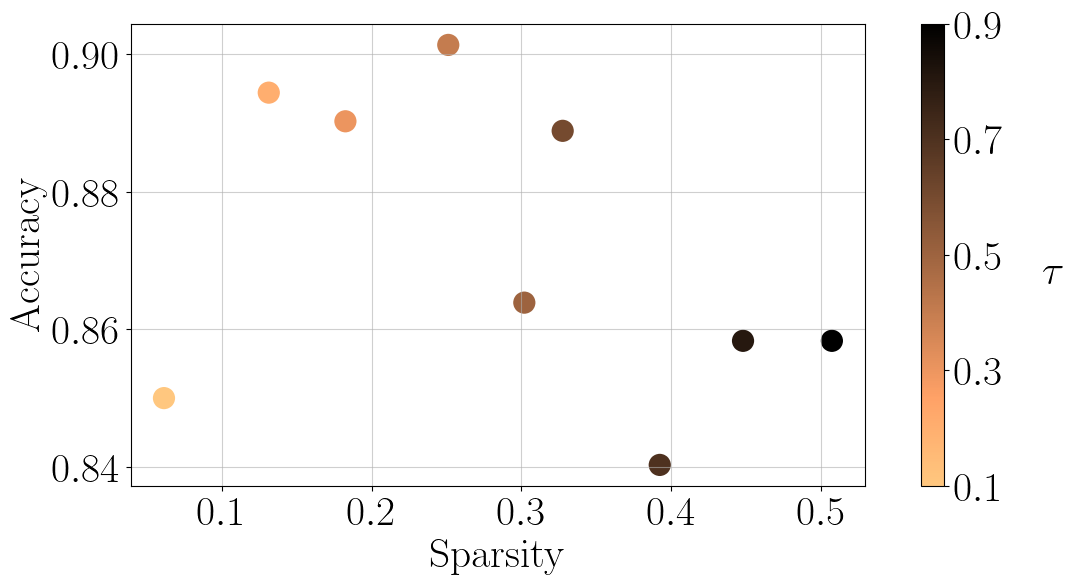

In [ ]:
metrics = pd.read_csv('Tau_vs_accuracy_sparsity.csv')

tau = metrics.Tau.values
sparsity = metrics.Sparsity_avg	.values
avg_acc = metrics.Accuracy_avg.values

plt.figure()
plt.scatter(sparsity, avg_acc, cmap=plt.colormaps.get_cmap('copper_r'),
            c=tau, linewidths=10)
plt.xlabel("Sparsity")
plt.ylabel("Accuracy")
plt.grid()
colorbar = plt.colorbar(pad=0.06)#, location='top', orientation='horizontal')
colorbar.set_label(r'$\tau$', labelpad=35, rotation=0)
colorbar.set_ticks([0.1, 0.3, 0.5, 0.7, 0.9])
#plt.savefig("Plots/sparsity_vs_acc_tau.png", bbox_inches='tight')
plt.show()

### Train with optimized hyperparams

In [ ]:
#metrics = pd.read_csv("models_metrics.csv")
torch.cuda.empty_cache()

autoencoder = network.cae_2(tau = 0.4, 
                           channels = 64, 
                           kernel_size = (1,1,3), 
                           stride = 1, 
                           )

snn =  network.snn_1(input_shape = INP_SHAPE, 
                     hidden = [64,128], 
                     timesteps = 29,
                     kernel = (1,1,4),
                     stride = (1,2,2),
                     beta = 0.9,
                     threshold = 0.8,
                     learn_thr = True, 
                     learn_beta = True,
                     surr_grad = surrogate.atan()
                     )
    
net = AE(autoencoder, snn).to(DEVICE)
optimizer = torch.optim.Adam(net.parameters(), lr = 1e-3)

trainer = Trainer(
                model = net,
                optimizer = optimizer,
                device = DEVICE,
                acc_steps = 1,
                patience = 20,
                model_path = "./models/cae_2_snn_1.pt" 
        )

trainer.fit(
                train_loader = train_loader,
                val_loader = val_loader,
                epochs = 50
        )

desc = "CAE (cae_2): 2 conv_layers, channels=64, kernel=(1,1,3), stride=1, tau=0.4,  \
        SNN (snn_1): 3 layers, neurons=[64,128], timesteps=29, kernel=(1,1,4) \
        stride=(1,2,2), beta=0.9, thr=0.8, learn_beta_thr = True, surr_grad = atan\\ \
        optimizer=Adam, lr=1e-3, epochs=50, patience=15"

row_data = {"name": "CAE-SNN1",
            "path": "cae_2_snn_1.pt",
            "description": desc,
            "params": utils_fn.count_params(net)}

#df = pd.concat([metrics, pd.DataFrame([row_data])], ignore_index=True)
#df.to_csv("models_metrics.csv", index=False)

Epoch 1 - train_loss: 0.3461 | train_acc: 0.7710 | val_loss: 0.1897 | val_acc: 0.9337
Epoch 6 - train_loss: 0.1205 | train_acc: 0.9471 | val_loss: 0.1184 | val_acc: 0.9564
Epoch 11 - train_loss: 0.0834 | train_acc: 0.9797 | val_loss: 0.2596 | val_acc: 0.8917
Epoch 16 - train_loss: 0.0712 | train_acc: 0.9869 | val_loss: 0.2749 | val_acc: 0.8018
Epoch 21 - train_loss: 0.0693 | train_acc: 0.9839 | val_loss: 0.2360 | val_acc: 0.8588
Early stopping at epoch 25


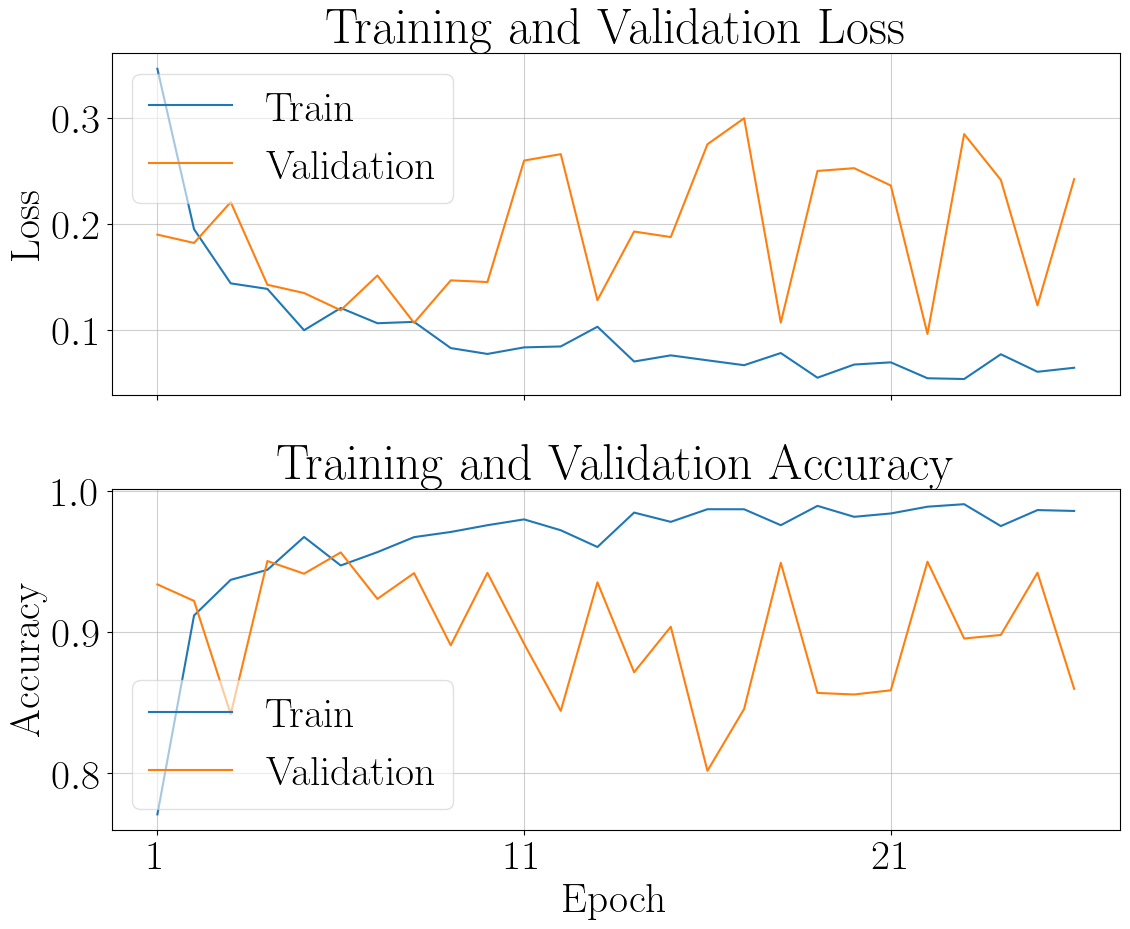

In [ ]:
plot_curves(trainer.train_loss_ls, trainer.val_loss_ls, 
                     trainer.train_acc_ls, trainer.val_acc_ls)

### Results on test set

In [ ]:
path = "./models/cae_2_snn_1.pt" 
checkpoint = torch.load(path, map_location=DEVICE)

autoencoder = network.cae_2(tau = 0.4, 
                           channels = 64, 
                           kernel_size = (1,1,3), 
                           stride = 1, 
                           )

snn =  network.snn_1(input_shape = INP_SHAPE, 
                     hidden = [64,128], 
                     timesteps = 29,
                     kernel = (1,1,4),
                     stride = (1,2,2),
                     beta = 0.9,
                     threshold = 0.8,
                     learn_thr = True, 
                     learn_beta = True,
                     surr_grad = SURROGATE_FN
                     )
    
net = AE(autoencoder, snn).to(DEVICE)
net.load_state_dict(checkpoint['model_state_dict'])
net.eval()

AE(
  (autoencoder): cae_2(
    (encoder): Sequential(
      (0): Conv3d(2, 64, kernel_size=(1, 1, 3), stride=(1, 1, 1), padding=same)
      (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv3d(64, 2, kernel_size=(1, 1, 3), stride=(1, 1, 1), padding=same)
      (4): BatchNorm3d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): HeavisideCustom()
    )
    (decoder): Sequential(
      (0): ConvTranspose3d(2, 64, kernel_size=(1, 1, 3), stride=(1, 1, 1), padding=(0, 0, 1))
      (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): ConvTranspose3d(64, 2, kernel_size=(1, 1, 3), stride=(1, 1, 1), padding=(0, 0, 1))
      (4): BatchNorm3d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): Sigmoid()
    )
  )
  (snn): snn_1(
    (avg_pool): AvgPool3d(kernel_size=(1, 1, 4), stride=(1, 2, 2), padding=0)
    (fc_in):

In [30]:
optimizer = torch.optim.Adam(net.parameters(), lr = 1e-3)
trainer = Trainer(
                model = net,
                optimizer = optimizer,
                device = DEVICE,
                model_path = path
        )

acc, prec, rec, f1, confusion_mx = trainer.classification_metrics(
                                dataloader=test_loader,
                                avg_type="macro",  
                                verbose=True
                            )

AVERAGE TYPE: macro

Accuracy: 0.9560
Precision: 0.9527
Recall: 0.9646              
F1 score: 0.9584

Classification Report:
               precision    recall  f1-score   support

     WALKING       0.97      0.94      0.95        79
     RUNNING       0.93      0.95      0.94        41
     SITTING       0.97      1.00      0.98        28
       HANDS       0.94      0.97      0.96        34

    accuracy                           0.96       182
   macro avg       0.95      0.96      0.96       182
weighted avg       0.96      0.96      0.96       182



In [39]:
df.loc[df["name"]=="CAE-SNN1", ["f1", "precision", "recall"]] = [f1, prec, rec]
df.to_csv("models_metrics.csv", index=False)

#### Plot the confusion matrix

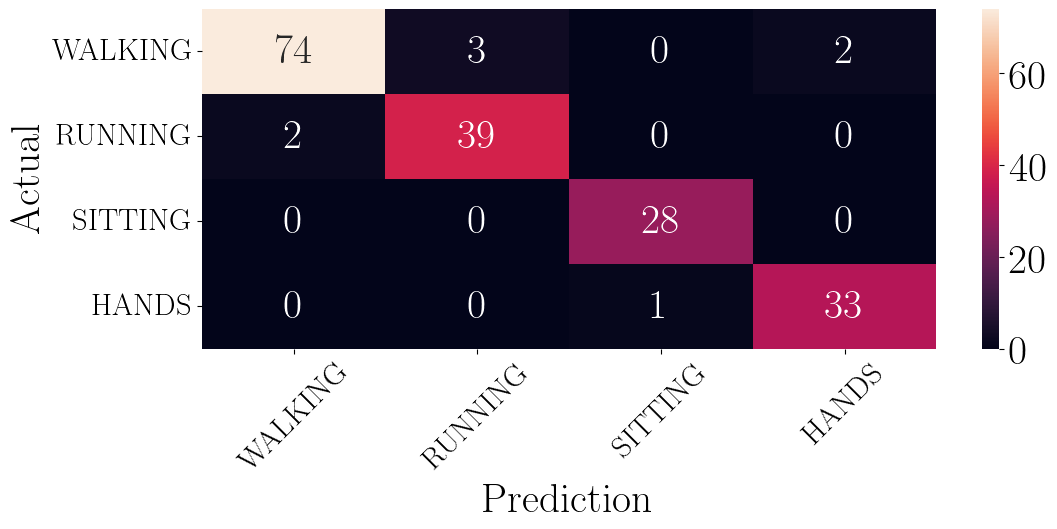

In [ ]:
sns.heatmap(confusion_mx,
            annot=True,
            fmt='g',
            xticklabels=['WALKING', 'RUNNING', 'SITTING', 'HANDS'],
            yticklabels=['WALKING', 'RUNNING', 'SITTING', 'HANDS']
            )

plt.ylabel('Actual')
plt.xlabel('Prediction')
plt.tick_params(axis='x', labelsize=22)  
plt.tick_params(axis='y', labelsize=22)  
plt.xticks(rotation=45)
plt.tight_layout() 
#plt.savefig("Plots/Conf_matrix/conf_mx_cae2_snn_1.png", bbox_inches='tight')
plt.show()

#### Number of trainable parameters and weight of the model

In [16]:
summary(net, input_size=(1, 2, 232, 10, 64))


Layer (type:depth-idx)                   Output Shape              Param #
CAE                                      --                        --
├─cae_2: 1-1                             [1, 2, 232, 10, 64]       --
│    └─Sequential: 2-1                   [1, 2, 232, 10, 64]       --
│    │    └─Conv3d: 3-1                  [1, 64, 232, 10, 64]      448
│    │    └─BatchNorm3d: 3-2             [1, 64, 232, 10, 64]      128
│    │    └─ReLU: 3-3                    [1, 64, 232, 10, 64]      --
│    │    └─Conv3d: 3-4                  [1, 2, 232, 10, 64]       386
│    │    └─BatchNorm3d: 3-5             [1, 2, 232, 10, 64]       4
│    │    └─HeavisideCustom: 3-6         [1, 2, 232, 10, 64]       --
│    └─Sequential: 2-2                   [1, 2, 232, 10, 64]       --
│    │    └─ConvTranspose3d: 3-7         [1, 64, 232, 10, 64]      448
│    │    └─BatchNorm3d: 3-8             [1, 64, 232, 10, 64]      128
│    │    └─ReLU: 3-9                    [1, 64, 232, 10, 64]      --
│    │    └

### Aircraft marshaling

Compare the encoding with the procedure in this paper

In [27]:
# create delta encoded dataloader
train_loader_enc, val_loader_enc, test_loader_enc = get_dataloaders_delta(train_dataset, val_dataset, test_dataset, batch_size=8)

#### Train the snn_1 network with delta thresholded encoded data

In [ ]:
seeds = [1, 22, 307, 5899, 75431]
accuracies, f1_scores = [], []
precisions, recalls = [], []

for seed in seeds:
        torch.manual_seed(seed) 
        classifier =  network.snn_1(input_shape = INP_SHAPE, 
                        hidden = [64,128], 
                        timesteps = 29,
                        kernel = (1,1,4),
                        stride = (1,2,2),
                        beta = 0.9,
                        threshold = 0.8,
                        learn_thr = True, 
                        learn_beta = True,
                        surr_grad = SURROGATE_FN
                        )

        net = SNN_CLSFF(classifier).to(DEVICE)

        optimizer = torch.optim.Adam(net.parameters(), lr = 1e-3)

        trainer = Trainer(
                        model = net,
                        optimizer = optimizer,
                        device = DEVICE,
                        Lambda = 1.0,
                        acc_steps = 1,
                        patience = 15,
                        model_path = None
                )

        trainer.fit(
                        train_loader = train_loader_enc,
                        val_loader = val_loader_enc,
                        epochs = 50
                )
        
        acc, prec, rec, f1, confusion_mx = trainer.classification_metrics(
                                dataloader=test_loader_enc,
                                avg_type="macro",  
                                verbose=False)
    
        accuracies.append(acc)
        precisions.append(prec)
        recalls.append(rec)
        f1_scores.append(f1)

accuracies = np.array(accuracies)
precisions = np.array(precisions)
recalls = np.array(recalls)
f1_scores = np.array(f1_scores)

print("-----------------------------------------------\n")
print(f"Accuracy:  mean={accuracies.mean():.4f}, std={accuracies.std():.4f}")
print(f"Precision: mean={precisions.mean():.4f}, std={precisions.std():.4f}")
print(f"Recall:    mean={recalls.mean():.4f}, std={recalls.std():.4f}")
print(f"F1-score:  mean={f1_scores.mean():.4f}, std={f1_scores.std():.4f}")

Epoch 1 - train_loss: 0.3989 | train_acc: 0.6184 | val_loss: 0.4152 | val_acc: 0.5495
Epoch 6 - train_loss: 0.0278 | train_acc: 0.9827 | val_loss: 0.4919 | val_acc: 0.7136
Epoch 11 - train_loss: 0.0039 | train_acc: 0.9982 | val_loss: 0.9633 | val_acc: 0.6567
Epoch 16 - train_loss: 0.0009 | train_acc: 0.9994 | val_loss: 1.0330 | val_acc: 0.6737
Epoch 21 - train_loss: 0.0005 | train_acc: 1.0000 | val_loss: 1.0698 | val_acc: 0.6659
Early stopping at epoch 21
AVERAGE TYPE: macro

Accuracy: 0.8297
Precision: 0.8415
Recall: 0.8157              
F1 score: 0.8262
Epoch 1 - train_loss: 0.3873 | train_acc: 0.6480 | val_loss: 0.6910 | val_acc: 0.5161
Epoch 6 - train_loss: 0.0224 | train_acc: 0.9804 | val_loss: 0.5581 | val_acc: 0.6820
Epoch 11 - train_loss: 0.0128 | train_acc: 0.9887 | val_loss: 1.0696 | val_acc: 0.6146
Epoch 16 - train_loss: 0.0003 | train_acc: 1.0000 | val_loss: 0.7609 | val_acc: 0.6940
Epoch 21 - train_loss: 0.0001 | train_acc: 1.0000 | val_loss: 0.7785 | val_acc: 0.6968
Early

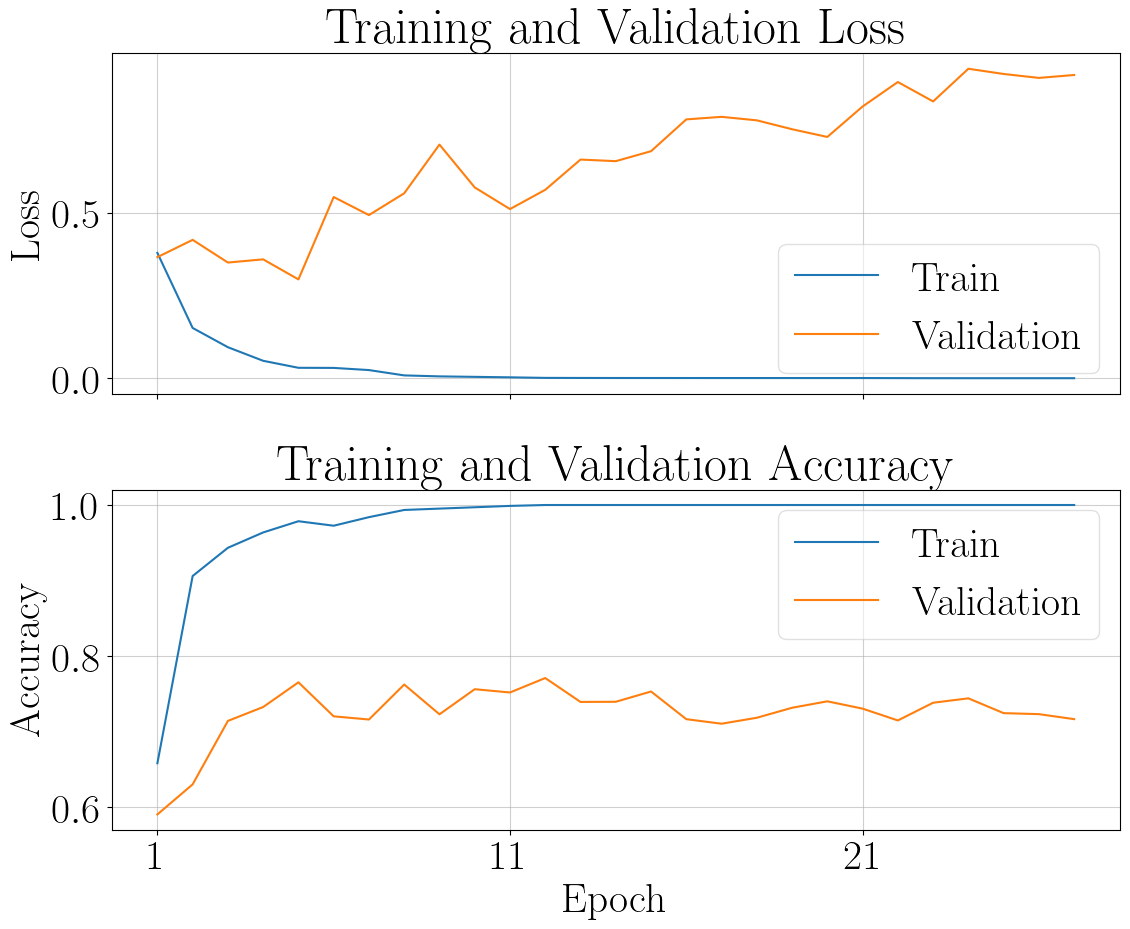

In [ ]:
plot_curves(trainer.train_loss_ls, trainer.val_loss_ls, 
                     trainer.train_acc_ls, trainer.val_acc_ls)

#### Results on test set of delta encoded + SNN

In [ ]:
path = "./models/delta_snn_1_1.pt" 
checkpoint = torch.load(path, map_location=DEVICE)

classifier =  network.snn_1(input_shape = INP_SHAPE, 
                     hidden = [64,128], 
                     timesteps = 29,
                     kernel = (1,1,4),
                     stride = (1,2,2),
                     beta = 0.9,
                     threshold = 0.8,
                     learn_thr = True, 
                     learn_beta = True,
                     surr_grad = SURROGATE_FN
                     )

net = SNN_CLSFF(classifier).to(DEVICE)
net.load_state_dict(checkpoint['model_state_dict'])
net.eval()

SNN_CLSFF(
  (snn): snn_1(
    (avg_pool): AvgPool3d(kernel_size=(1, 1, 4), stride=(1, 2, 2), padding=0)
    (fc_in): Linear(in_features=155, out_features=64, bias=True)
    (lif_in): Leaky()
    (fc_hidden): Linear(in_features=64, out_features=128, bias=True)
    (lif_hidden): Leaky()
    (fc_out): Linear(in_features=2048, out_features=4, bias=True)
    (li_out): Leaky()
  )
)

In [26]:
acc, prec, rec, f1, confusion_mx = trainer.classification_metrics(
                                dataloader=test_loader_enc,
                                avg_type="macro",  
                                verbose=True
                            )

AVERAGE TYPE: macro

Accuracy: 0.7857
Precision: 0.8078
Recall: 0.7505              
F1 score: 0.7528

Classification Report:
               precision    recall  f1-score   support

     WALKING       0.87      0.94      0.90        79
     RUNNING       0.53      0.68      0.60        41
     SITTING       0.97      1.00      0.98        28
       HANDS       0.87      0.38      0.53        34

    accuracy                           0.79       182
   macro avg       0.81      0.75      0.75       182
weighted avg       0.81      0.79      0.78       182



In [92]:
df.loc[df["name"]=="Delta", ["f1", "precision", "recall"]] = [f1, prec, rec]
df.to_csv("models_metrics.csv", index=False)

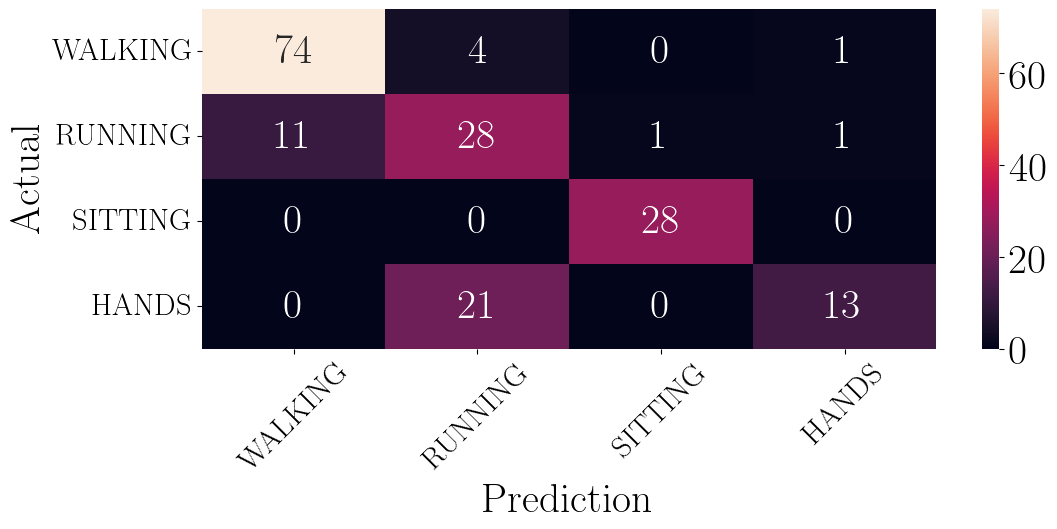

In [ ]:
sns.heatmap(confusion_mx,
            annot=True,
            fmt='g',
            xticklabels=['WALKING', 'RUNNING', 'SITTING', 'HANDS'],
            yticklabels=['WALKING', 'RUNNING', 'SITTING', 'HANDS']
            )

plt.ylabel('Actual')
plt.xlabel('Prediction')
plt.tick_params(axis='x', labelsize=22)  
plt.tick_params(axis='y', labelsize=22)  
plt.xticks(rotation=45)
plt.tight_layout() 
#plt.savefig("Plots/Conf_matrix/conf_mx_delta_snn.pdf", bbox_inches='tight')
plt.show()

### Sparsity of various encoding methods

In [ ]:
path = "./models/cae_2_snn_1.pt" 
checkpoint = torch.load(path, map_location=DEVICE)

autoencoder = network.cae_2(tau = 0.4, 
                           channels = 64, 
                           kernel_size = (1,1,3), 
                           stride = 1, 
                           )

snn =  network.snn_1(input_shape = INP_SHAPE, 
                     hidden = [64,128], 
                     timesteps = 29,
                     kernel = (1,1,4),
                     stride = (1,2,2),
                     beta = 0.9,
                     threshold = 0.8,
                     learn_thr = True, 
                     learn_beta = True,
                     surr_grad = SURROGATE_FN
                     )
    
cae = AE(autoencoder, snn).to(DEVICE)
cae.load_state_dict(checkpoint['model_state_dict'])
cae.eval()

path = "./models/scae_snn_1.pt" 
checkpoint = torch.load(path, map_location=DEVICE)

autoencoder = network.scae(channels = 64, 
                           kernel_size = (1,1,3),
                           stride = 1, 
                           timesteps = 1,
                           beta = 0.9, 
                           threshold = 0.8, 
                           learn_beta = True, 
                           learn_threshold = True, 
                           surr_grad = SURROGATE_FN
                           )

snn =  network.snn_1(input_shape = INP_SHAPE, 
                     hidden = [64,128], 
                     timesteps = 29,
                     kernel = (1,1,4),
                     stride = (1,2,2),
                     beta = 0.9,
                     threshold = 0.8,
                     learn_thr = True, 
                     learn_beta = True,
                     surr_grad = SURROGATE_FN
                     )

scae = AE(autoencoder, snn).to(DEVICE)
scae.load_state_dict(checkpoint['model_state_dict'])
scae.eval()

SCAE(
  (autoencoder): scae(
    (enc_conv1): Conv3d(2, 64, kernel_size=(1, 1, 3), stride=(1, 1, 1), padding=same)
    (enc_bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc_lif1): Leaky()
    (enc_conv2): Conv3d(64, 2, kernel_size=(1, 1, 3), stride=(1, 1, 1), padding=same)
    (enc_bn2): BatchNorm3d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc_lif2): Leaky()
    (dec_conv1): ConvTranspose3d(2, 64, kernel_size=(1, 1, 3), stride=(1, 1, 1), padding=(0, 0, 1))
    (dec_bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dec_lif1): Leaky()
    (dec_conv2): ConvTranspose3d(64, 2, kernel_size=(1, 1, 3), stride=(1, 1, 1), padding=(0, 0, 1))
    (dec_bn2): BatchNorm3d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (sigmoid): Sigmoid()
  )
  (snn): snn_1(
    (avg_pool): AvgPool3d(kernel_size=(1, 1, 4), stride=(1, 2, 2), padding=0)
    (fc_in): Linear(in_fea

In [ ]:
loss_fn = torch.nn.MSELoss()

loss_cae, loss_scae = 0, 0
sparsity_cae, sparsity_scae = 0, 0

with torch.no_grad():
        for X, _, _ in test_loader:
            X = X.to(DEVICE).float()
            
            spk_percent, decoded, spk_out = scae(X)
            spk_percent1, decoded1, spk_out1 = cae(X)

            loss_scae += loss_fn(decoded.squeeze(0), X)
            loss_cae += loss_fn(decoded1.squeeze(0), X)

            sparsity_scae += 1 - spk_percent.item()
            sparsity_cae += 1 - spk_percent1.item()
            
        loss_cae = loss_cae / len(test_loader)
        loss_scae = loss_scae / len(test_loader)
        sparsity_cae = sparsity_cae / len(test_loader)
        sparsity_scae = sparsity_scae / len(test_loader)

sparsity_delta = 0
with torch.no_grad():
        for X in test_loader_enc:
            X = X[0]
            sparsity_delta += 1 - X.abs().mean().item()

sparsity_delta =  sparsity_delta / len(test_loader_enc)

print(f"Reconstruction error of CAE: {loss_cae.item():.4f}")
print(f"Reconstruction error of SCAE: {loss_scae.item():.4f}\n")
print(f"Average sparsity of CAE encoding: {sparsity_cae:.4f}")
print(f"Average sparsity of SCAE encoding: {sparsity_scae:.4f}")
print(f"Average sparsity of Delta encoding: {sparsity_delta:.4f}")

Reconstruction error of CAE: 0.0530
Reconstruction error of SCAE: 0.0500

Average sparsity of CAE encoding: 0.2653
Average sparsity of SCAE encoding: 0.8180
Average sparsity of Delta encoding: 0.7171


In [39]:
metrics.loc[metrics.name=='SCAE-SNN1', 'sparsity'] = round(sparsity_scae, 4)
metrics.loc[metrics.name=='CAE-SNN1', 'sparsity'] = round(sparsity_cae, 4)
metrics.loc[metrics.name=='Delta', 'sparsity'] = round(sparsity_delta, 4)
metrics.to_csv("models_metrics.csv", index=False)

### Train a Direct-SNN with linear layers

In [ ]:
seeds = [1, 22, 307, 5899, 75431]
accuracies, f1_scores = [], []
precisions, recalls = [], []

for seed in seeds:
        torch.manual_seed(seed) 
        classifier =  network.snn_2(input_shape = INP_SHAPE, 
                                hidden = [64,128,256],
                                timesteps = 29,
                                kernel = (1,1,4),
                                stride = (1,2,2),
                                beta = 0.9,
                                threshold = 0.5,
                                learn_thr = True, 
                                learn_beta = True,
                                surr_grad = SURROGATE_FN
                                )

        net = SNN_CLSFF(classifier).to(DEVICE)

        optimizer = torch.optim.Adam(net.parameters(), lr = 1e-3)

        trainer = Trainer(
                        model = net,
                        optimizer = optimizer,
                        device = DEVICE,
                        acc_steps = 1,
                        patience = 20,
                        model_path = None
                )

        trainer.fit(
                        train_loader = train_loader,
                        val_loader = val_loader,
                        epochs = 50
                )
        
        acc, prec, rec, f1, confusion_mx = trainer.classification_metrics(
                                dataloader=test_loader,
                                avg_type="macro",  
                                verbose=False)
        
        accuracies.append(acc)
        precisions.append(prec)
        recalls.append(rec)
        f1_scores.append(f1)

accuracies = np.array(accuracies)
precisions = np.array(precisions)
recalls = np.array(recalls)
f1_scores = np.array(f1_scores)

print("-----------------------------------------------\n")
print(f"Accuracy:  mean={accuracies.mean():.4f}, std={accuracies.std():.4f}")
print(f"Precision: mean={precisions.mean():.4f}, std={precisions.std():.4f}")
print(f"Recall:    mean={recalls.mean():.4f}, std={recalls.std():.4f}")
print(f"F1-score:  mean={f1_scores.mean():.4f}, std={f1_scores.std():.4f}")


Epoch 1 - train_loss: 0.6368 | train_acc: 0.2677 | val_loss: 1.8094 | val_acc: 0.1303
Epoch 6 - train_loss: 0.4833 | train_acc: 0.2533 | val_loss: 0.6050 | val_acc: 0.2223
Epoch 11 - train_loss: 0.4993 | train_acc: 0.3029 | val_loss: 0.6399 | val_acc: 0.2552
Epoch 16 - train_loss: 0.5347 | train_acc: 0.2344 | val_loss: 0.6412 | val_acc: 0.2272
Epoch 21 - train_loss: 0.5347 | train_acc: 0.2344 | val_loss: 0.6412 | val_acc: 0.2272
Early stopping at epoch 22
AVERAGE TYPE: macro

Accuracy: 0.4341
Precision: 0.1085
Recall: 0.2500              
F1 score: 0.1513


/home/eleonora/envsnn1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/eleonora/envsnn1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/eleonora/envsnn1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Epoch 1 - train_loss: 0.6545 | train_acc: 0.2640 | val_loss: 0.6412 | val_acc: 0.2272
Epoch 6 - train_loss: 0.5371 | train_acc: 0.2362 | val_loss: 0.6412 | val_acc: 0.2272
Epoch 11 - train_loss: 0.5347 | train_acc: 0.2344 | val_loss: 0.6412 | val_acc: 0.2272
Epoch 16 - train_loss: 0.5347 | train_acc: 0.2344 | val_loss: 0.6412 | val_acc: 0.2272
Early stopping at epoch 20
AVERAGE TYPE: macro

Accuracy: 0.4341
Precision: 0.1085
Recall: 0.2500              
F1 score: 0.1513


/home/eleonora/envsnn1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/eleonora/envsnn1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/eleonora/envsnn1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Epoch 1 - train_loss: 0.5706 | train_acc: 0.2589 | val_loss: 0.6412 | val_acc: 0.2272
Epoch 6 - train_loss: 0.5336 | train_acc: 0.2508 | val_loss: 0.7097 | val_acc: 0.1468
Epoch 11 - train_loss: 0.5347 | train_acc: 0.2344 | val_loss: 0.6412 | val_acc: 0.2272
Epoch 16 - train_loss: 0.5347 | train_acc: 0.2344 | val_loss: 0.6412 | val_acc: 0.2272
Early stopping at epoch 20
AVERAGE TYPE: macro

Accuracy: 0.4341
Precision: 0.1085
Recall: 0.2500              
F1 score: 0.1513


/home/eleonora/envsnn1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/eleonora/envsnn1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/eleonora/envsnn1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Epoch 1 - train_loss: 0.5914 | train_acc: 0.2477 | val_loss: 0.6412 | val_acc: 0.2272
Epoch 6 - train_loss: 0.5360 | train_acc: 0.2344 | val_loss: 0.6412 | val_acc: 0.2272
Epoch 11 - train_loss: 0.5347 | train_acc: 0.2344 | val_loss: 0.6412 | val_acc: 0.2272
Epoch 16 - train_loss: 0.5347 | train_acc: 0.2344 | val_loss: 0.6412 | val_acc: 0.2272
Early stopping at epoch 20
AVERAGE TYPE: macro

Accuracy: 0.4341
Precision: 0.1085
Recall: 0.2500              
F1 score: 0.1513


/home/eleonora/envsnn1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/eleonora/envsnn1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/eleonora/envsnn1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Epoch 1 - train_loss: 0.6486 | train_acc: 0.2700 | val_loss: 0.6412 | val_acc: 0.2272
Epoch 6 - train_loss: 0.5349 | train_acc: 0.2409 | val_loss: 0.6412 | val_acc: 0.2272
Epoch 11 - train_loss: 0.5347 | train_acc: 0.2344 | val_loss: 0.6412 | val_acc: 0.2272
Epoch 16 - train_loss: 0.5423 | train_acc: 0.2389 | val_loss: 0.6412 | val_acc: 0.2272
Early stopping at epoch 20
AVERAGE TYPE: macro

Accuracy: 0.4341
Precision: 0.1085
Recall: 0.2500              
F1 score: 0.1513
-----------------------------------------------

Accuracy:  mean=0.4341, std=0.0000
Precision: mean=0.1085, std=0.0000
Recall:    mean=0.2500, std=0.0000
F1-score:  mean=0.1513, std=0.0000


/home/eleonora/envsnn1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/eleonora/envsnn1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/eleonora/envsnn1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


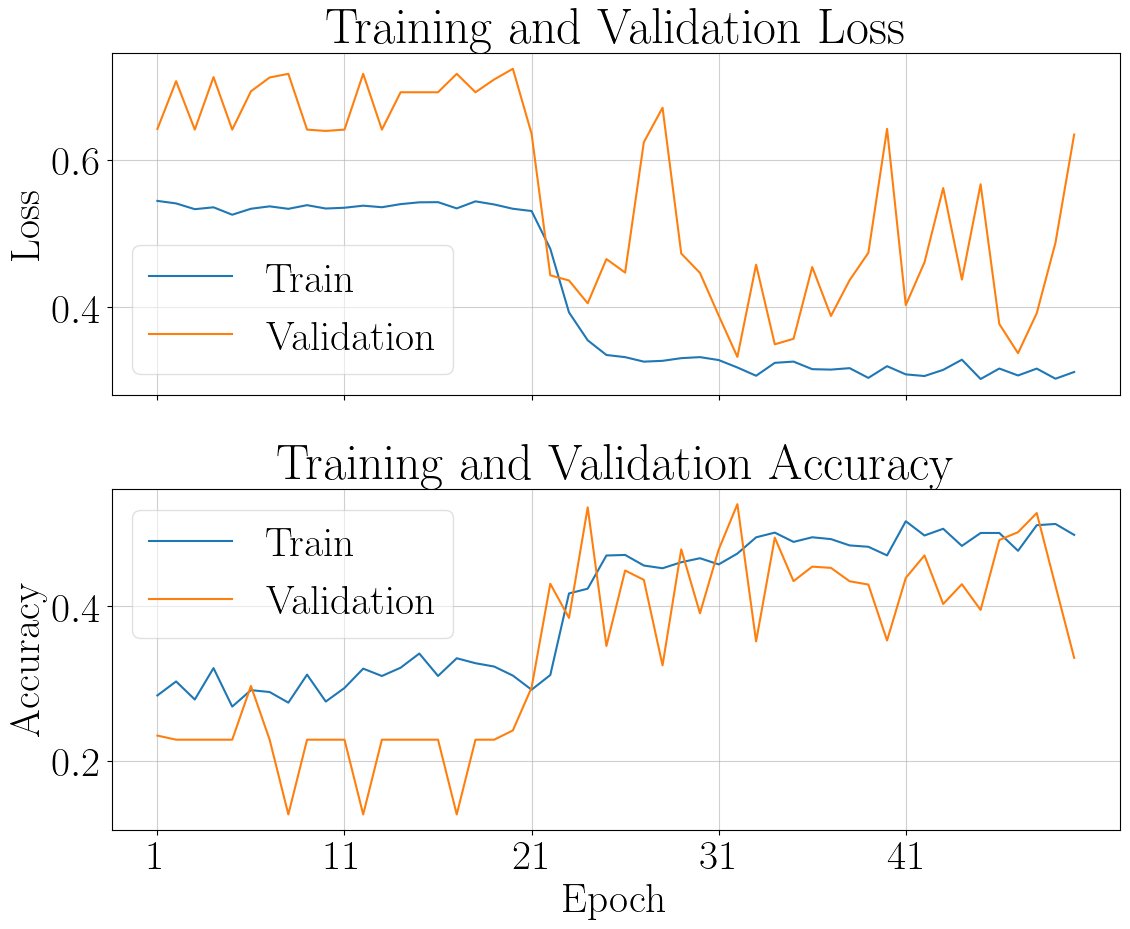

In [ ]:
plot_curves(trainer.train_loss_ls, trainer.val_loss_ls, 
                     trainer.train_acc_ls, trainer.val_acc_ls)

#### Results on test set of Direct-SNN

In [ ]:
checkpoint = torch.load(path, map_location=DEVICE)

classifier =  network.snn_2(input_shape = INP_SHAPE, 
                            hidden = [64,128,256],
                            timesteps = 29,
                            kernel = (1,1,4),
                            stride = (1,2,2),
                            beta = 0.9,
                            threshold = 0.8,
                            learn_thr = True, 
                            learn_beta = True,
                            surr_grad = SURROGATE_FN
                            )

net = SNN_CLSFF(classifier).to(DEVICE)
net.load_state_dict(checkpoint['model_state_dict'])
net.eval()

SNN_CLSFF(
  (snn): snn_2(
    (avg_pool): AvgPool3d(kernel_size=(1, 1, 4), stride=(1, 2, 2), padding=0)
    (fc_in): Linear(in_features=155, out_features=64, bias=True)
    (lif_in): Leaky()
    (fc_hidden1): Linear(in_features=64, out_features=128, bias=True)
    (lif_hidden1): Leaky()
    (fc_hidden2): Linear(in_features=128, out_features=256, bias=True)
    (lif_hidden2): Leaky()
    (fc_out): Linear(in_features=4096, out_features=4, bias=True)
    (lif_out): Leaky()
  )
)

In [19]:
acc, prec, rec, f1, confusion_mx = trainer.classification_metrics(
                                dataloader=test_loader,
                                avg_type="macro",  
                                verbose=True
                            )

AVERAGE TYPE: macro

Accuracy: 0.6319
Precision: 0.5061
Recall: 0.5604              
F1 score: 0.5142

Classification Report:
               precision    recall  f1-score   support

     WALKING       0.64      0.96      0.77        79
     RUNNING       0.00      0.00      0.00        41
     SITTING       0.57      0.75      0.65        28
       HANDS       0.82      0.53      0.64        34

    accuracy                           0.63       182
   macro avg       0.51      0.56      0.51       182
weighted avg       0.52      0.63      0.55       182



In [105]:
df.loc[df["name"]=="Direct-SNN2", ["f1", "precision", "recall"]] = [f1, prec, rec]
df.to_csv("models_metrics.csv", index=False)

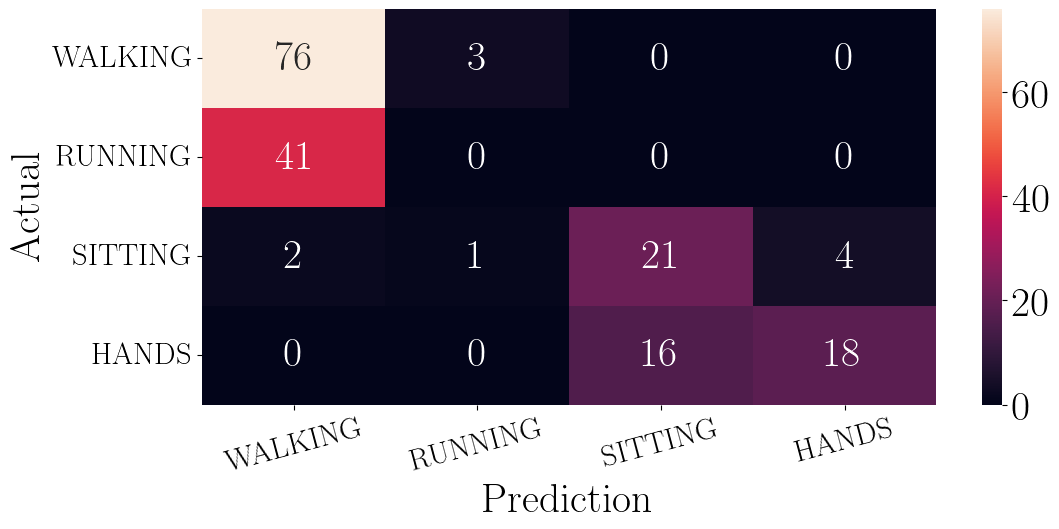

In [ ]:
sns.heatmap(confusion_mx,
            annot=True,
            fmt='g',
            xticklabels=['WALKING', 'RUNNING', 'SITTING', 'HANDS'],
            yticklabels=['WALKING', 'RUNNING', 'SITTING', 'HANDS']
            )

plt.ylabel('Actual')
plt.xlabel('Prediction')
plt.tick_params(axis='x', labelsize=22)  
plt.tick_params(axis='y', labelsize=22)  
plt.xticks(rotation=15)
plt.tight_layout() 
#plt.savefig("Plots/Conf_matrix/conf_mx_direct_snn_2.pdf", bbox_inches='tight')
plt.show()

### Train a Direct-SNN with conv layer

In [ ]:
seeds = [1, 22, 307, 5899, 75431]
accuracies, f1_scores = [], []
precisions, recalls = [], []

for seed in seeds:
        torch.manual_seed(seed) 
        classifier =  network.snn_conv2(input_shape = INP_SHAPE, 
                                channels = [64, 128, 128],
                                timesteps = 29,
                                kernel = (1,1,3),
                                stride = (1,1,1),
                                beta = 0.9,
                                threshold = 0.5,
                                learn_thr = True, 
                                learn_beta = True,
                                surr_grad = SURROGATE_FN
                                )

        net = SNN_CLSFF(classifier).to(DEVICE)

        optimizer = torch.optim.Adam(net.parameters(), lr = 1e-3)

        trainer = Trainer(
                        model = net,
                        optimizer = optimizer,
                        device = DEVICE,
                        acc_steps = 1,
                        patience = 20,
                        model_path = None
                )

        trainer.fit(
                        train_loader = train_loader,
                        val_loader = val_loader,
                        epochs = 50
                )
        
        acc, prec, rec, f1, confusion_mx = trainer.classification_metrics(
                                dataloader=test_loader,
                                avg_type="macro",  
                                verbose=False)
        
        accuracies.append(acc)
        precisions.append(prec)
        recalls.append(rec)
        f1_scores.append(f1)

accuracies = np.array(accuracies)
precisions = np.array(precisions)
recalls = np.array(recalls)
f1_scores = np.array(f1_scores)

print("-----------------------------------------------\n")
print(f"Accuracy:  mean={accuracies.mean():.4f}, std={accuracies.std():.4f}")
print(f"Precision: mean={precisions.mean():.4f}, std={precisions.std():.4f}")
print(f"Recall:    mean={recalls.mean():.4f}, std={recalls.std():.4f}")
print(f"F1-score:  mean={f1_scores.mean():.4f}, std={f1_scores.std():.4f}")

Epoch 1 - train_loss: 5.8675 | train_acc: 0.2416 | val_loss: 8.4768 | val_acc: 0.1303
Epoch 6 - train_loss: 5.9224 | train_acc: 0.2344 | val_loss: 8.4768 | val_acc: 0.1303
Epoch 11 - train_loss: 4.3752 | train_acc: 0.3321 | val_loss: 4.1290 | val_acc: 0.2272
Epoch 16 - train_loss: 2.3577 | train_acc: 0.2357 | val_loss: 3.1020 | val_acc: 0.2272
Epoch 21 - train_loss: 2.4073 | train_acc: 0.2370 | val_loss: 3.0755 | val_acc: 0.2272
Epoch 26 - train_loss: 2.2840 | train_acc: 0.2370 | val_loss: 2.9981 | val_acc: 0.2425
Epoch 31 - train_loss: 2.3928 | train_acc: 0.2344 | val_loss: 3.0389 | val_acc: 0.2272
Early stopping at epoch 33
AVERAGE TYPE: macro

Accuracy: 0.4341
Precision: 0.1085
Recall: 0.2500              
F1 score: 0.1513


/home/eleonora/envsnn1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/eleonora/envsnn1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/eleonora/envsnn1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Epoch 1 - train_loss: 5.8720 | train_acc: 0.2392 | val_loss: 8.4768 | val_acc: 0.1303
Epoch 6 - train_loss: 5.9224 | train_acc: 0.2344 | val_loss: 8.4768 | val_acc: 0.1303
Epoch 11 - train_loss: 5.9224 | train_acc: 0.2344 | val_loss: 8.4768 | val_acc: 0.1303
Epoch 16 - train_loss: 5.9224 | train_acc: 0.2344 | val_loss: 8.4768 | val_acc: 0.1303
Epoch 21 - train_loss: 0.5347 | train_acc: 0.2344 | val_loss: 0.6412 | val_acc: 0.2272
Epoch 26 - train_loss: 0.5348 | train_acc: 0.2344 | val_loss: 0.6412 | val_acc: 0.2272
Epoch 31 - train_loss: 0.5347 | train_acc: 0.2344 | val_loss: 0.6412 | val_acc: 0.2272
Epoch 36 - train_loss: 0.5343 | train_acc: 0.2357 | val_loss: 0.6354 | val_acc: 0.2571
Epoch 41 - train_loss: 0.5347 | train_acc: 0.2344 | val_loss: 0.6412 | val_acc: 0.2272
Epoch 46 - train_loss: 0.5347 | train_acc: 0.2344 | val_loss: 0.6412 | val_acc: 0.2272
AVERAGE TYPE: macro

Accuracy: 0.4341
Precision: 0.1085
Recall: 0.2500              
F1 score: 0.1513


/home/eleonora/envsnn1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/eleonora/envsnn1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/eleonora/envsnn1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Epoch 1 - train_loss: 4.3387 | train_acc: 0.2390 | val_loss: 7.8122 | val_acc: 0.2272
Epoch 6 - train_loss: 4.3894 | train_acc: 0.2344 | val_loss: 7.8122 | val_acc: 0.2272


KeyboardInterrupt: 

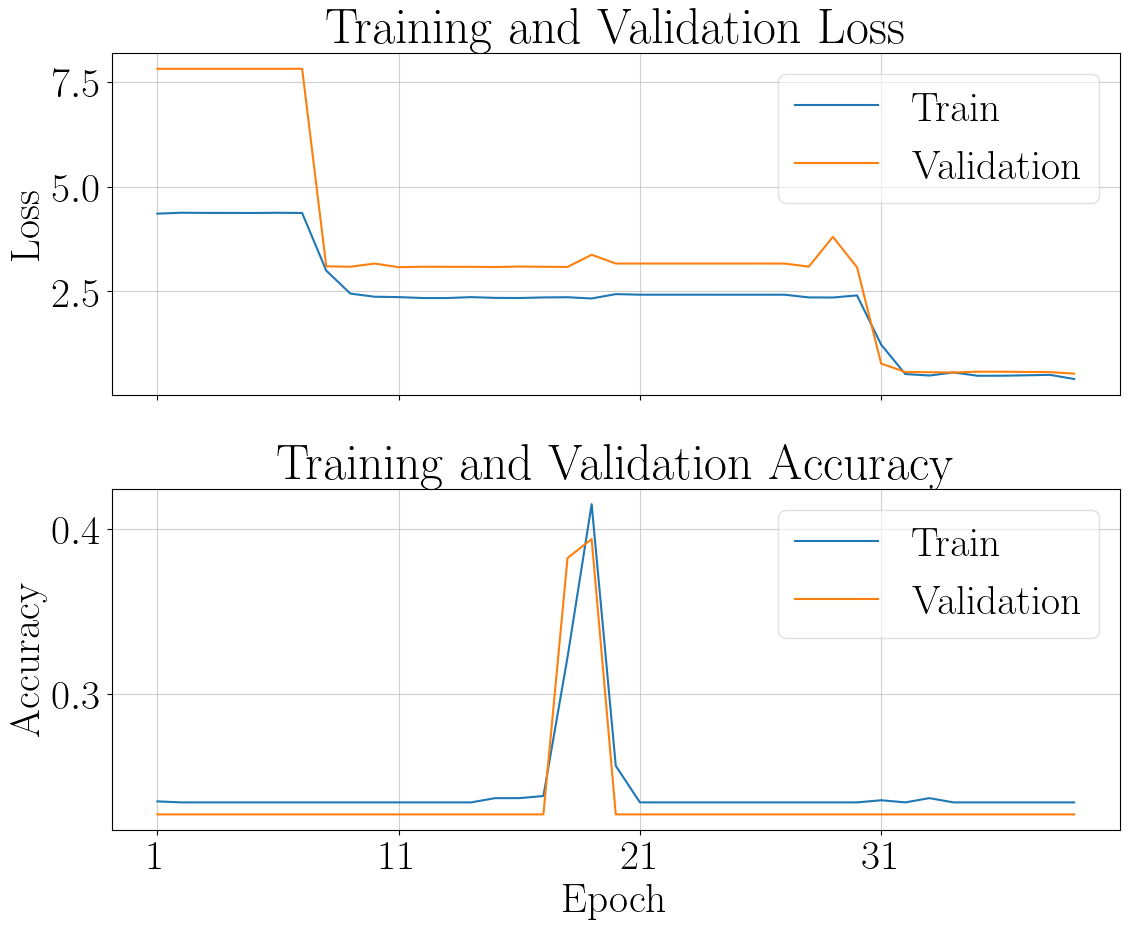

In [ ]:
plot_curves(trainer.train_loss_ls, trainer.val_loss_ls, 
                     trainer.train_acc_ls, trainer.val_acc_ls)

#### Results on test set of Direct-SNN (conv layers)

In [ ]:
checkpoint = torch.load(path, map_location=DEVICE)

classifier =  network.snn_conv3(input_shape = INP_SHAPE, 
                            channels = [64, 128, 128],
                            timesteps = 29,
                            kernel = (1,1,3),
                            stride = (1,1,1),
                            beta = 0.9,
                            threshold = 0.8,
                            learn_thr = True, 
                            learn_beta = True,
                            surr_grad = SURROGATE_FN
                            )

net = SNN_CLSFF(classifier).to(DEVICE)
net.load_state_dict(checkpoint['model_state_dict'])
net.eval()

SNN_CLSFF(
  (snn): snn_conv3(
    (conv1): Conv3d(2, 64, kernel_size=(1, 1, 3), stride=(1, 1, 1), padding=same)
    (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (lif1): Leaky()
    (conv2): Conv3d(64, 128, kernel_size=(1, 1, 3), stride=(1, 1, 1), padding=same)
    (bn2): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (lif2): Leaky()
    (conv3): Conv3d(128, 128, kernel_size=(1, 1, 3), stride=(1, 1, 1), padding=same)
    (bn3): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (lif3): Leaky()
    (fc_out): Linear(in_features=655360, out_features=4, bias=True)
    (lif_out): Leaky()
  )
)

In [9]:
acc, prec, rec, f1, confusion_mx = trainer.classification_metrics(
                                dataloader=test_loader,
                                avg_type="macro",  
                                verbose=True
                                )

AVERAGE TYPE: macro

Accuracy: 0.4341
Precision: 0.1085
Recall: 0.2500              
F1 score: 0.1513

Classification Report:
               precision    recall  f1-score   support

     WALKING       0.43      1.00      0.61        79
     RUNNING       0.00      0.00      0.00        41
     SITTING       0.00      0.00      0.00        28
       HANDS       0.00      0.00      0.00        34

    accuracy                           0.43       182
   macro avg       0.11      0.25      0.15       182
weighted avg       0.19      0.43      0.26       182



/home/eleonora/envsnn1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/eleonora/envsnn1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/eleonora/envsnn1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [17]:
df.loc[df["name"]=="Direct-SNN-Conv3_1", ["f1", "precision", "recall"]] = [f1, prec, rec]
df.to_csv("models_metrics.csv", index=False)

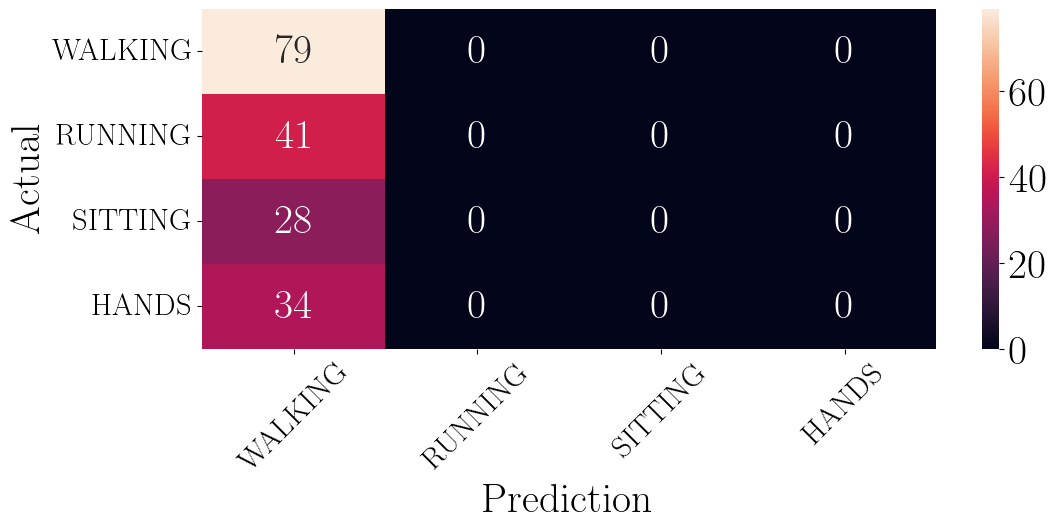

In [12]:
sns.heatmap(confusion_mx,
            annot=True,
            fmt='g',
            xticklabels=['WALKING', 'RUNNING', 'SITTING', 'HANDS'],
            yticklabels=['WALKING', 'RUNNING', 'SITTING', 'HANDS']
            )

plt.ylabel('Actual')
plt.xlabel('Prediction')
plt.tick_params(axis='x', labelsize=22)  
plt.tick_params(axis='y', labelsize=22)  
plt.xticks(rotation=45)
plt.tight_layout() 
#plt.savefig("Plots/Conf_matrix/conf_mx_direct_snn_conv_1.pdf", bbox_inches='tight')
plt.show()

In [62]:
summary(net, input_size=(1, 2, 232, 10, 64))

Layer (type:depth-idx)                   Output Shape              Param #
SNN_CLSFF                                --                        --
├─snn_conv2: 1-1                         [29, 1, 4]                --
│    └─Conv3d: 2-1                       [1, 64, 8, 10, 64]        448
│    └─BatchNorm3d: 2-2                  [1, 64, 8, 10, 64]        128
│    └─Leaky: 2-3                        [1, 64, 8, 10, 64]        2
│    └─Conv3d: 2-4                       [1, 128, 8, 10, 64]       24,704
│    └─BatchNorm3d: 2-5                  [1, 128, 8, 10, 64]       256
│    └─Leaky: 2-6                        [1, 128, 8, 10, 64]       2
│    └─Linear: 2-7                       [1, 4]                    2,621,444
│    └─Leaky: 2-8                        [1, 4]                    1
│    └─Conv3d: 2-9                       [1, 64, 8, 10, 64]        (recursive)
│    └─BatchNorm3d: 2-10                 [1, 64, 8, 10, 64]        (recursive)
│    └─Leaky: 2-11                       [1, 64, 8, 10, 

### Train of CNN network (DISC paper)

In [ ]:
metrics = pd.read_csv("models_metrics.csv")
torch.cuda.empty_cache()
classifier =  network.cnn_disc()

net = SNN_CLSFF(classifier).to(device)

optimizer = torch.optim.Adam(net.parameters(), lr = 1e-3)

trainer = Trainer(
                model = net,
                optimizer = optimizer,
                device = device,
                acc_steps = 1,
                patience = 20,
                model_path = "./models1/disc_cnn.pt" 
        )

trainer.fit(
                train_loader = train_loader,
                val_loader = val_loader,
                epochs = 50
        )

desc = 'DISC (cnn_disc): 6 conv, channels=[2,8,16,32,64,128], kernel=3, stride=2, padding=1 \
        + 2 linear, neurons=[64,4]. Dropout(0.2) before each linear. Relu activation'

row_data = {"name": "Disc-CNN",
            "path": "disc_cnn.pt",
            "description": desc,
            "params": utils_fn.count_params(net)}

df = pd.concat([metrics, pd.DataFrame([row_data])], ignore_index=True)
df.to_csv("models_metrics.csv", index=False)

Epoch 1 - train_loss: 0.5404 | train_acc: 0.3071 | val_loss: 0.7169 | val_acc: 0.1303
Epoch 6 - train_loss: 0.5222 | train_acc: 0.3557 | val_loss: 0.6670 | val_acc: 0.2272
Epoch 11 - train_loss: 0.3637 | train_acc: 0.8634 | val_loss: 0.4588 | val_acc: 0.7696
Epoch 16 - train_loss: 0.4429 | train_acc: 0.4556 | val_loss: 0.4590 | val_acc: 0.5596
Epoch 21 - train_loss: 0.4295 | train_acc: 0.5623 | val_loss: 0.3768 | val_acc: 0.9201
Epoch 26 - train_loss: 0.3219 | train_acc: 0.9340 | val_loss: 0.3638 | val_acc: 0.9637
Epoch 31 - train_loss: 0.3237 | train_acc: 0.9249 | val_loss: 0.3958 | val_acc: 0.8542
Epoch 36 - train_loss: 0.3195 | train_acc: 0.9261 | val_loss: 0.3655 | val_acc: 0.9780
Epoch 41 - train_loss: 0.3016 | train_acc: 0.9685 | val_loss: 0.4023 | val_acc: 0.9049
Epoch 46 - train_loss: 0.2965 | train_acc: 0.9810 | val_loss: 0.3794 | val_acc: 0.9635


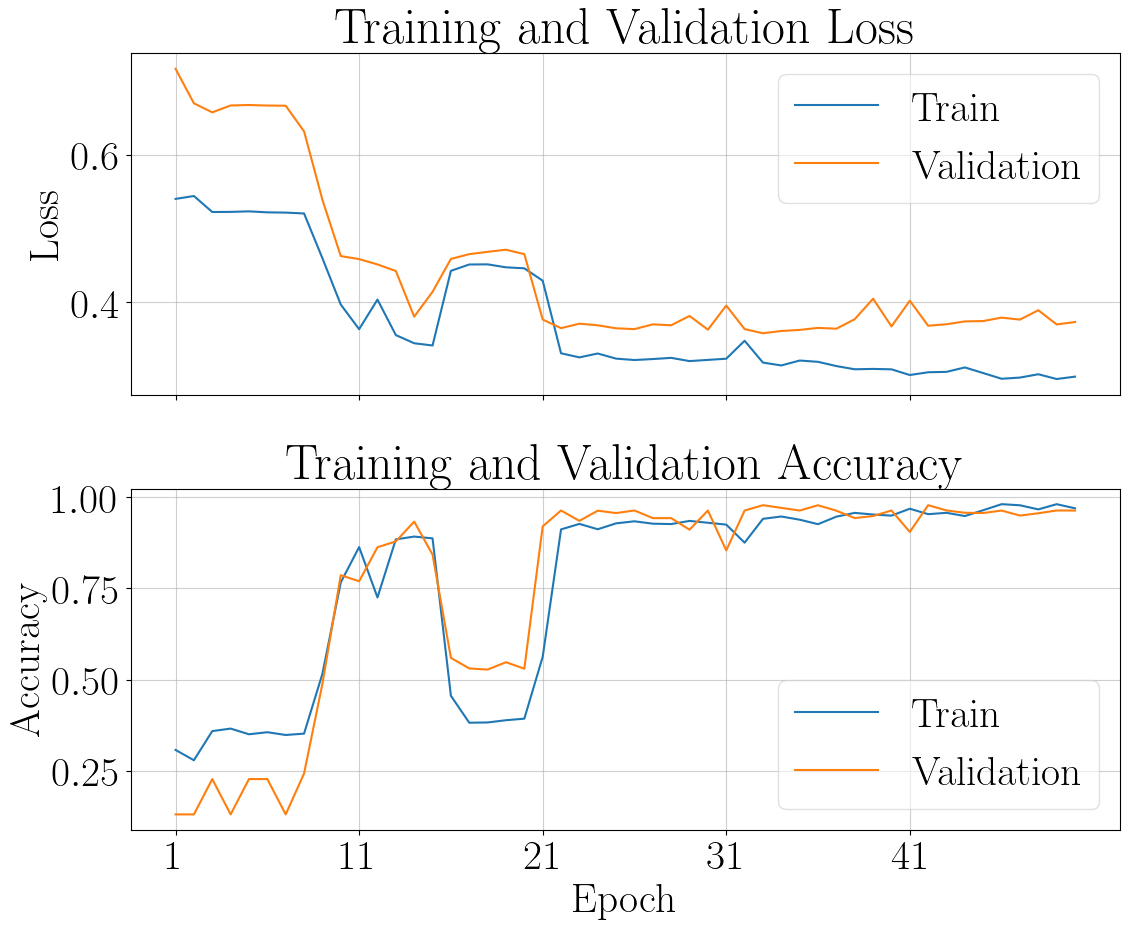

In [ ]:
plot_curves(trainer.train_loss_ls, trainer.val_loss_ls, 
                     trainer.train_acc_ls, trainer.val_acc_ls)

#### Results on test set

In [9]:
path = "./models1/disc_cnn.pt" 
checkpoint = torch.load(path, map_location=device)

classifier =  network.cnn_disc()

net = SNN_CLSFF(classifier).to(device)
net.load_state_dict(checkpoint['model_state_dict'])
net.eval()

SNN_CLSFF(
  (snn): cnn_disc(
    (conv_layers): Sequential(
      (0): Conv3d(2, 8, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      (1): ReLU()
      (2): Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      (3): ReLU()
      (4): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      (5): ReLU()
      (6): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      (7): ReLU()
      (8): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      (9): ReLU()
      (10): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      (11): ReLU()
    )
    (dropout): Dropout(p=0.2, inplace=False)
    (dense1): Linear(in_features=512, out_features=64, bias=True)
    (dense2): Linear(in_features=64, out_features=4, bias=True)
  )
)

In [10]:
acc, prec, rec, f1, confusion_mx = trainer.classification_metrics(
                                dataloader=test_loader,
                                avg_type="macro",  
                                verbose=True
                                )

df.loc[df["name"]=="Disc-CNN", ["f1", "precision", "recall"]] = [f1, prec, rec]
df.to_csv("models_metrics.csv", index=False)

AVERAGE TYPE: macro

Accuracy: 0.9066
Precision: 0.8916
Recall: 0.8740              
F1 score: 0.8746

Classification Report:
               precision    recall  f1-score   support

     WALKING       0.95      1.00      0.98        79
     RUNNING       1.00      0.93      0.96        41
     SITTING       0.69      0.89      0.78        28
       HANDS       0.92      0.68      0.78        34

    accuracy                           0.91       182
   macro avg       0.89      0.87      0.87       182
weighted avg       0.92      0.91      0.91       182



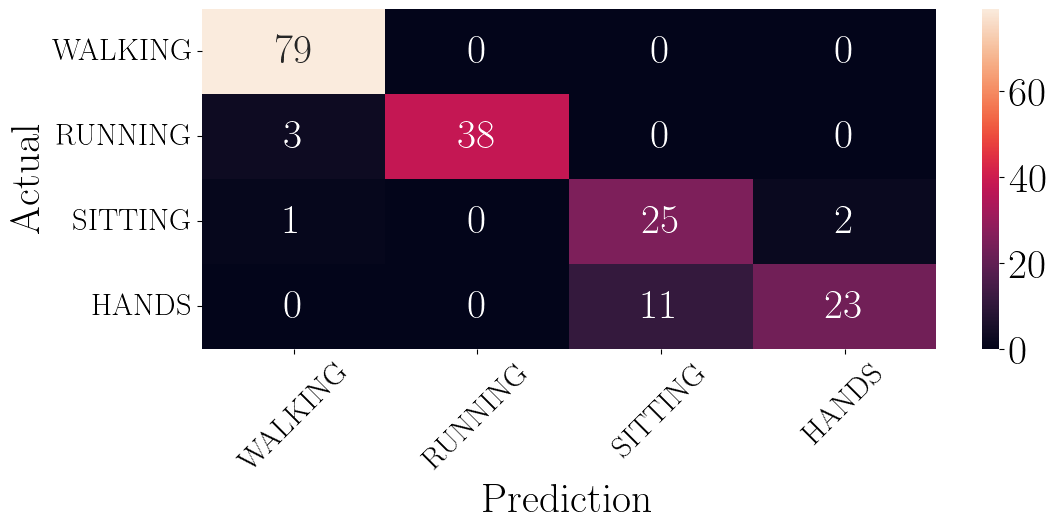

In [ ]:
sns.heatmap(confusion_mx,
            annot=True,
            fmt='g',
            xticklabels=['WALKING', 'RUNNING', 'SITTING', 'HANDS'],
            yticklabels=['WALKING', 'RUNNING', 'SITTING', 'HANDS']
            )

plt.ylabel('Actual')
plt.xlabel('Prediction')
plt.tick_params(axis='x', labelsize=22)  
plt.tick_params(axis='y', labelsize=22)  
plt.xticks(rotation=45)
plt.tight_layout() 
#plt.savefig("Plots/Conf_matrix/conf_mx_disc_cnn.pdf", bbox_inches='tight')
plt.show()

### Average number of spikes per neuron

In [98]:
# Spiking autoencoder + SNN for classification
class SCAE(nn.Module):
    def __init__(self, autoencoder, snn):
        super(SCAE, self).__init__()
        self.autoencoder = autoencoder
        self.snn = snn

    def forward(self, x):
        encoded, decoded = self.autoencoder(x)
        x1, x1, x3 = self.snn(encoded)  
        n_spikes = encoded.abs().mean()
        return x1, x1, x3

In [ ]:
path = "./models/scae_snn_1.pt" 
checkpoint = torch.load(path, map_location=DEVICE)

autoencoder = network.scae(channels = 64, 
                           kernel_size = (1,1,3),
                           stride = 1, 
                           timesteps = 1,
                           beta = 0.9, 
                           threshold = 0.8, 
                           learn_beta = True, 
                           learn_threshold = True, 
                           surr_grad = SURROGATE_FN
                           )

snn =  network.snn_1(input_shape = INP_SHAPE, 
                     hidden = [64,128], 
                     timesteps = 29,
                     kernel = (1,1,4),
                     stride = (1,2,2),
                     beta = 0.9,
                     threshold = 0.8,
                     learn_thr = True, 
                     learn_beta = True,
                     surr_grad = SURROGATE_FN
                     )

scae = SCAE(autoencoder, snn).to(DEVICE)
scae.load_state_dict(checkpoint['model_state_dict'])
scae.eval()

SCAE(
  (autoencoder): scae(
    (enc_conv1): Conv3d(2, 64, kernel_size=(1, 1, 3), stride=(1, 1, 1), padding=same)
    (enc_bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc_lif1): Leaky()
    (enc_conv2): Conv3d(64, 2, kernel_size=(1, 1, 3), stride=(1, 1, 1), padding=same)
    (enc_bn2): BatchNorm3d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc_lif2): Leaky()
    (dec_conv1): ConvTranspose3d(2, 64, kernel_size=(1, 1, 3), stride=(1, 1, 1), padding=(0, 0, 1))
    (dec_bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dec_lif1): Leaky()
    (dec_conv2): ConvTranspose3d(64, 2, kernel_size=(1, 1, 3), stride=(1, 1, 1), padding=(0, 0, 1))
    (dec_bn2): BatchNorm3d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (sigmoid): Sigmoid()
  )
  (snn): snn_1(
    (avg_pool): AvgPool3d(kernel_size=(1, 1, 4), stride=(1, 2, 2), padding=0)
    (fc_in): Linear(in_fea

In [132]:
# Initialize accumulators
total_spikes_in, total_neurons_in = 0, 0
total_spikes_hid, total_neurons_hid = 0, 0
total_spikes_out, total_neurons_out = 0, 0

scae.eval()
with torch.no_grad():
    for X, _, y in test_loader:
        spk_in, spk_hid, spk_out = scae(X.to(device))

        # Input layer
        total_spikes_in += spk_in.sum().item()
        total_neurons_in += spk_in.numel()

        # Hidden layer
        total_spikes_hid += spk_hid.sum().item()
        total_neurons_hid += spk_hid.numel()

        # Output layer
        total_spikes_out += spk_out.sum().item()
        total_neurons_out += spk_out.numel()

# Compute average activity per layer
avg_activity_in = total_spikes_in / total_neurons_in
avg_activity_hid = total_spikes_hid / total_neurons_hid
avg_activity_out = total_spikes_out / total_neurons_out

print(f"Average spike activity per layer:\n"
      f"Input: {avg_activity_in:.4f}, "
      f"Hidden: {avg_activity_hid:.4f}, "
      f"Output: {avg_activity_out:.4f}")


Average spike activity per layer:
Input: 0.0115, Hidden: 0.0115, Output: 0.1345


In [133]:
(avg_activity_in + avg_activity_hid + avg_activity_out)/3

0.052506670771756976

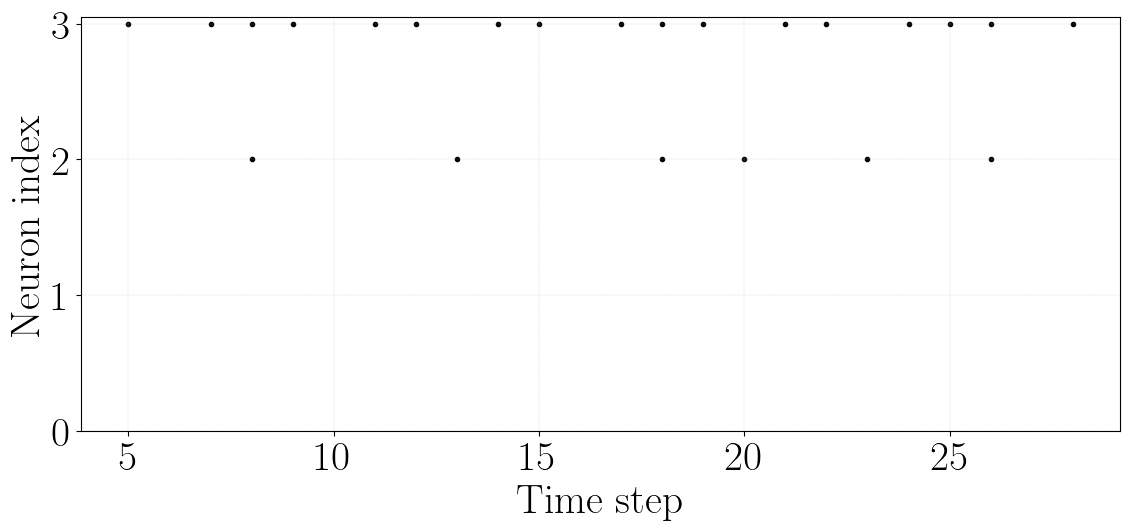

In [ ]:
raster_plot(spk_out.squeeze()) # layer output

In [126]:
class CAE(nn.Module):
    def __init__(self, autoencoder, snn):
        super(CAE, self).__init__()
        self.autoencoder = autoencoder
        self.snn = snn

    def forward(self, x):
        encoded, decoded = self.autoencoder(x)
        x1, x1, x3 = self.snn(encoded)  
        n_spikes = encoded.abs().mean()
        return x1, x1, x3 

In [ ]:
path = "./models/cae_2_snn_1.pt" 
checkpoint = torch.load(path, map_location=DEVICE)

autoencoder = network.cae_2(tau = 0.4, 
                           channels = 64, 
                           kernel_size = (1,1,3), 
                           stride = 1, 
                           )

snn =  network.snn_1(input_shape = INP_SHAPE, 
                     hidden = [64,128], 
                     timesteps = 29,
                     kernel = (1,1,4),
                     stride = (1,2,2),
                     beta = 0.9,
                     threshold = 0.8,
                     learn_thr = True, 
                     learn_beta = True,
                     surr_grad = SURROGATE_FN
                     )
    
cae = CAE(autoencoder, snn).to(DEVICE)
cae.load_state_dict(checkpoint['model_state_dict'])
cae.eval()

CAE(
  (autoencoder): cae_2(
    (encoder): Sequential(
      (0): Conv3d(2, 64, kernel_size=(1, 1, 3), stride=(1, 1, 1), padding=same)
      (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv3d(64, 2, kernel_size=(1, 1, 3), stride=(1, 1, 1), padding=same)
      (4): BatchNorm3d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): HeavisideCustom()
    )
    (decoder): Sequential(
      (0): ConvTranspose3d(2, 64, kernel_size=(1, 1, 3), stride=(1, 1, 1), padding=(0, 0, 1))
      (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): ConvTranspose3d(64, 2, kernel_size=(1, 1, 3), stride=(1, 1, 1), padding=(0, 0, 1))
      (4): BatchNorm3d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): Sigmoid()
    )
  )
  (snn): snn_1(
    (avg_pool): AvgPool3d(kernel_size=(1, 1, 4), stride=(1, 2, 2), padding=0)
    (fc_in)

In [128]:
# Initialize accumulators
total_spikes_in, total_neurons_in = 0, 0
total_spikes_hid, total_neurons_hid = 0, 0
total_spikes_out, total_neurons_out = 0, 0

scae.eval()
with torch.no_grad():
    for X, _, y in test_loader:
        spk_in, spk_hid, spk_out = cae(X.to(device))

        # Input layer
        total_spikes_in += spk_in.sum().item()
        total_neurons_in += spk_in.numel()

        # Hidden layer
        total_spikes_hid += spk_hid.sum().item()
        total_neurons_hid += spk_hid.numel()

        # Output layer
        total_spikes_out += spk_out.sum().item()
        total_neurons_out += spk_out.numel()

# Compute average activity per layer
avg_activity_in = total_spikes_in / total_neurons_in
avg_activity_hid = total_spikes_hid / total_neurons_hid
avg_activity_out = total_spikes_out / total_neurons_out

print(f"Average spike activity per layer:\n"
      f"Input: {avg_activity_in:.4f}, "
      f"Hidden: {avg_activity_hid:.4f}, "
      f"Output: {avg_activity_out:.4f}")


Average spike activity per layer:
Input: 0.0120, Hidden: 0.0120, Output: 0.1559


In [131]:
(avg_activity_in + avg_activity_hid + avg_activity_out)/3

0.059996733690160405

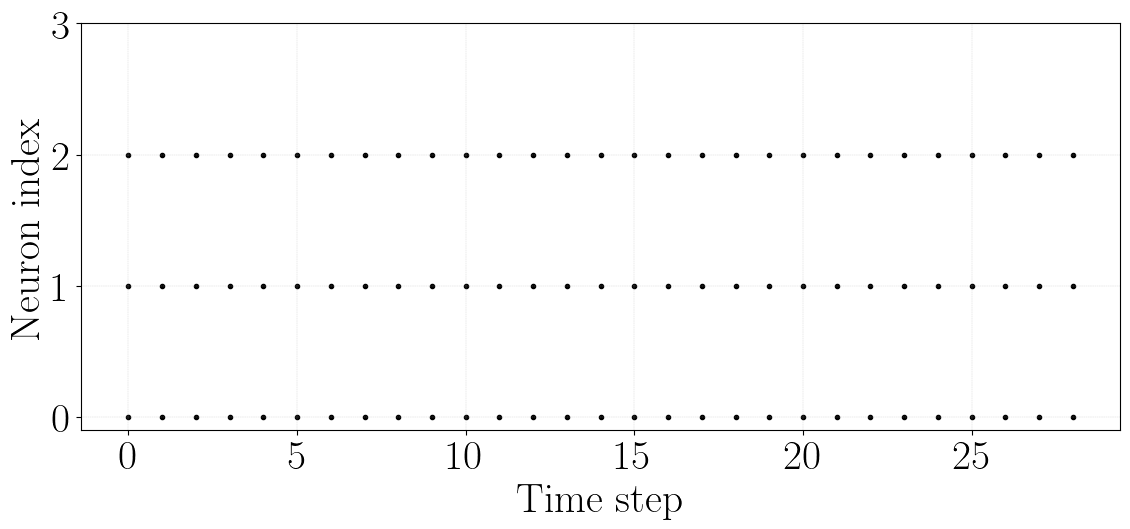

In [ ]:
raster_plot(spk_out.squeeze()) # layer output

In [146]:
class SNN_CLSFF(nn.Module):
    def __init__(self, snn):
        super(SNN_CLSFF, self).__init__()
        self.snn = snn

    def forward(self, x):
        x1, x2, x3 = self.snn(x)  
        n_spikes = x.abs().mean()
        return x1, x2, x3

In [141]:
path = "./models/delta_snn_1.pt" 
checkpoint = torch.load(path, map_location=device)

classifier =  network.snn_1(input_shape = INP_SHAPE, 
                     hidden = [64,128], 
                     timesteps = 29,
                     kernel = (1,1,4),
                     stride = (1,2,2),
                     beta = 0.9,
                     threshold = 0.8,
                     learn_thr = True, 
                     learn_beta = True,
                     surr_grad = surrogate.atan()
                     )

delta = SNN_CLSFF(classifier).to(device)
delta.load_state_dict(checkpoint['model_state_dict'])
delta.eval()

SNN_CLSFF(
  (snn): snn_1(
    (avg_pool): AvgPool3d(kernel_size=(1, 1, 4), stride=(1, 2, 2), padding=0)
    (fc_in): Linear(in_features=155, out_features=64, bias=True)
    (lif_in): Leaky()
    (fc_hidden): Linear(in_features=64, out_features=128, bias=True)
    (lif_hidden): Leaky()
    (fc_out): Linear(in_features=2048, out_features=4, bias=True)
    (li_out): Leaky()
  )
)

In [142]:
# Initialize accumulators
total_spikes_in, total_neurons_in = 0, 0
total_spikes_hid, total_neurons_hid = 0, 0
total_spikes_out, total_neurons_out = 0, 0

with torch.no_grad():
    for X, _, y in test_loader_enc:
        spk_in, spk_hid, spk_out = delta(X.to(device))

        # Input layer
        total_spikes_in += spk_in.sum().item()
        total_neurons_in += spk_in.numel()

        # Hidden layer
        total_spikes_hid += spk_hid.sum().item()
        total_neurons_hid += spk_hid.numel()

        # Output layer
        total_spikes_out += spk_out.sum().item()
        total_neurons_out += spk_out.numel()

# Compute average activity per layer
avg_activity_in = total_spikes_in / total_neurons_in
avg_activity_hid = total_spikes_hid / total_neurons_hid
avg_activity_out = total_spikes_out / total_neurons_out

print(f"Average spike activity per layer:\n"
      f"Input: {avg_activity_in:.4f}, "
      f"Hidden: {avg_activity_hid:.4f}, "
      f"Output: {avg_activity_out:.4f}")


Average spike activity per layer:
Input: 0.0276, Hidden: 0.0179, Output: 0.2333


In [143]:
(avg_activity_in + avg_activity_hid + avg_activity_out)/3

0.09292312280930277

In [149]:
class SNN_CLSFF(nn.Module):
    def __init__(self, snn):
        super(SNN_CLSFF, self).__init__()
        self.snn = snn

    def forward(self, x):
        x1, x2, x3, x4 = self.snn(x)  
        n_spikes = x.abs().mean()
        return x1, x2, x3, x4

In [ ]:
path = "./models/direct_snn_2.pt" 
checkpoint = torch.load(path, map_location=DEVICE)

classifier =  network.snn_2(input_shape = INP_SHAPE, 
                            hidden = [64,128,256],
                            timesteps = 29,
                            kernel = (1,1,4),
                            stride = (1,2,2),
                            beta = 0.9,
                            threshold = 0.8,
                            learn_thr = True, 
                            learn_beta = True,
                            surr_grad = SURROGATE_FN
                            )

net = SNN_CLSFF(classifier).to(DEVICE)
net.load_state_dict(checkpoint['model_state_dict'])
net.eval()

SNN_CLSFF(
  (snn): snn_2(
    (avg_pool): AvgPool3d(kernel_size=(1, 1, 4), stride=(1, 2, 2), padding=0)
    (fc_in): Linear(in_features=155, out_features=64, bias=True)
    (lif_in): Leaky()
    (fc_hidden1): Linear(in_features=64, out_features=128, bias=True)
    (lif_hidden1): Leaky()
    (fc_hidden2): Linear(in_features=128, out_features=256, bias=True)
    (lif_hidden2): Leaky()
    (fc_out): Linear(in_features=4096, out_features=4, bias=True)
    (lif_out): Leaky()
  )
)

In [ ]:
# Initialize accumulators
total_spikes_in, total_neurons_in = 0, 0
total_spikes_hid1, total_neurons_hid1 = 0, 0
total_spikes_hid2, total_neurons_hid2 = 0, 0
total_spikes_out, total_neurons_out = 0, 0

with torch.no_grad():
    for X, _, y in test_loader:
        spk_in, spk_hid1, spk_hid2, spk_out = net(X.to(DEVICE))

        # Input layer
        total_spikes_in += spk_in.sum().item()
        total_neurons_in += spk_in.numel()

        # Hidden layer 1
        total_spikes_hid1 += spk_hid1.sum().item()
        total_neurons_hid1 += spk_hid1.numel()

        # Hidden layer 2
        total_spikes_hid2 += spk_hid2.sum().item()
        total_neurons_hid2 += spk_hid2.numel()

        # Output layer
        total_spikes_out += spk_out.sum().item()
        total_neurons_out += spk_out.numel()

# Compute average activity per layer
avg_activity_in = total_spikes_in / total_neurons_in
avg_activity_hid1 = total_spikes_hid1 / total_neurons_hid1
avg_activity_hid2 = total_spikes_hid2 / total_neurons_hid2
avg_activity_out = total_spikes_out / total_neurons_out

(avg_activity_in + avg_activity_hid1 + avg_activity_hid2+ avg_activity_out)/4


0.039643941389967796

In [157]:
class SNN_CLSFF(nn.Module):
    def __init__(self, snn):
        super(SNN_CLSFF, self).__init__()
        self.snn = snn

    def forward(self, x):
        x1, x2, x3 = self.snn(x)  
        n_spikes = x.abs().mean()
        return x1, x2, x3

In [ ]:
path = "./models/direct_snn_conv_2.pt" 
checkpoint = torch.load(path, map_location=DEVICE)

classifier =  network.snn_conv2(input_shape = INP_SHAPE, 
                            channels = [64, 128, 128],
                            timesteps = 29,
                            kernel = (1,1,3),
                            stride = (1,1,1),
                            beta = 0.9,
                            threshold = 0.8,
                            learn_thr = True, 
                            learn_beta = True,
                            surr_grad = SURROGATE_FN
                            )

net = SNN_CLSFF(classifier).to(DEVICE)
net.load_state_dict(checkpoint['model_state_dict'])
net.eval()

SNN_CLSFF(
  (snn): snn_conv2(
    (conv1): Conv3d(2, 64, kernel_size=(1, 1, 3), stride=(1, 1, 1), padding=same)
    (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (lif1): Leaky()
    (conv2): Conv3d(64, 128, kernel_size=(1, 1, 3), stride=(1, 1, 1), padding=same)
    (bn2): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (lif2): Leaky()
    (fc_out): Linear(in_features=655360, out_features=4, bias=True)
    (lif_out): Leaky()
  )
)

In [ ]:
# Initialize accumulators
total_spikes_in, total_neurons_in = 0, 0
total_spikes_hid, total_neurons_hid = 0, 0
total_spikes_out, total_neurons_out = 0, 0

with torch.no_grad():
    for X, _, y in test_loader:
        spk_in, spk_hid, spk_out = net(X.to(DEVICE))

        # Input layer
        total_spikes_in += spk_in.sum().item()
        total_neurons_in += spk_in.numel()

        # Hidden layer
        total_spikes_hid += spk_hid.sum().item()
        total_neurons_hid += spk_hid.numel()

        # Output layer
        total_spikes_out += spk_out.sum().item()
        total_neurons_out += spk_out.numel()

# Compute average activity per layer
avg_activity_in = total_spikes_in / total_neurons_in
avg_activity_hid = total_spikes_hid / total_neurons_hid
avg_activity_out = total_spikes_out / total_neurons_out

print(f"Average spike activity per layer:\n"
      f"Input: {avg_activity_in:.4f}, "
      f"Hidden: {avg_activity_hid:.4f}, "
      f"Output: {avg_activity_out:.4f}")


Average spike activity per layer:
Input: 0.1442, Hidden: 0.1804, Output: 0.7279


In [163]:
avg_activity_out

0.7278798787419477

In [160]:
(avg_activity_in + avg_activity_hid + avg_activity_out)/3

0.35081594596536103

### Inference time on test set

In [ ]:
path = "./models/cae_2_snn_1.pt" 
checkpoint = torch.load(path, map_location=DEVICE)

autoencoder = network.cae_2(tau = 0.4, 
                           channels = 64, 
                           kernel_size = (1,1,3), 
                           stride = 1, 
                           )

snn =  network.snn_1(input_shape = INP_SHAPE, 
                     hidden = [64,128], 
                     timesteps = 29,
                     kernel = (1,1,4),
                     stride = (1,2,2),
                     beta = 0.9,
                     threshold = 0.8,
                     learn_thr = True, 
                     learn_beta = True,
                     surr_grad = SURROGATE_FN
                     )
    
cae = CAE(autoencoder, snn).to(DEVICE)
cae.load_state_dict(checkpoint['model_state_dict'])
cae.eval()

path = "./models/scae_snn_1.pt" 
checkpoint = torch.load(path, map_location=DEVICE)

autoencoder = network.scae(channels = 64, 
                           kernel_size = (1,1,3),
                           stride = 1, 
                           timesteps = 1,
                           beta = 0.9, 
                           threshold = 0.8, 
                           learn_beta = True, 
                           learn_threshold = True, 
                           surr_grad = SURROGATE_FN
                           )

snn =  network.snn_1(input_shape = INP_SHAPE, 
                     hidden = [64,128], 
                     timesteps = 29,
                     kernel = (1,1,4),
                     stride = (1,2,2),
                     beta = 0.9,
                     threshold = 0.8,
                     learn_thr = True, 
                     learn_beta = True,
                     surr_grad = SURROGATE_FN
                     )

scae = SCAE(autoencoder, snn).to(DEVICE)
scae.load_state_dict(checkpoint['model_state_dict'])
scae.eval()

SCAE(
  (autoencoder): scae(
    (enc_conv1): Conv3d(2, 64, kernel_size=(1, 1, 3), stride=(1, 1, 1), padding=same)
    (enc_bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc_lif1): Leaky()
    (enc_conv2): Conv3d(64, 2, kernel_size=(1, 1, 3), stride=(1, 1, 1), padding=same)
    (enc_bn2): BatchNorm3d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc_lif2): Leaky()
    (dec_conv1): ConvTranspose3d(2, 64, kernel_size=(1, 1, 3), stride=(1, 1, 1), padding=(0, 0, 1))
    (dec_bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dec_lif1): Leaky()
    (dec_conv2): ConvTranspose3d(64, 2, kernel_size=(1, 1, 3), stride=(1, 1, 1), padding=(0, 0, 1))
    (dec_bn2): BatchNorm3d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (sigmoid): Sigmoid()
  )
  (snn): snn_1(
    (avg_pool): AvgPool3d(kernel_size=(1, 1, 4), stride=(1, 2, 2), padding=0)
    (fc_in): Linear(in_fea

In [70]:
n_runs = 100

cae_enc_times, cae_cls_times = [], []
scae_enc_times, scae_cls_times = [], []

for _ in tqdm.tqdm(range(n_runs)):
    # CAE+SNN inference
    enc, clss = utils_fn.inference_time(cae, test_loader, device)
    cae_enc_times.append(enc)
    cae_cls_times.append(clss)
    
    # SCAE+SNN inference
    enc, clss = utils_fn.inference_time(scae, test_loader, device)
    scae_enc_times.append(enc)
    scae_cls_times.append(clss)

# Compute averages
cae_enc_avg = np.mean(cae_enc_times)
cae_cls_avg = np.mean(cae_cls_times)
scae_enc_avg = np.mean(scae_enc_times)
scae_cls_avg = np.mean(scae_cls_times)

# Print results
print(f"Average inference time over {n_runs} runs:")
print(f"CAE+SNN: encoding {cae_enc_avg:.4f} - classification {cae_cls_avg:.4f}")
print(f"SCAE+SNN: encoding {scae_enc_avg:.4f} - classification {scae_cls_avg:.4f}")

100%|██████████| 100/100 [13:26<00:00,  8.07s/it]

Average inference time over 100 runs:
CAE+SNN: encoding 0.0006 - classification 0.0186
SCAE+SNN: encoding 0.0012 - classification 0.0184


In [ ]:
path = "./models/delta_snn_1.pt" 
checkpoint = torch.load(path, map_location=DEVICE)

classifier =  network.snn_1(input_shape = INP_SHAPE, 
                     hidden = [64,128], 
                     timesteps = 29,
                     kernel = (1,1,4),
                     stride = (1,2,2),
                     beta = 0.9,
                     threshold = 0.8,
                     learn_thr = True, 
                     learn_beta = True,
                     surr_grad = SURROGATE_FN
                     )

net = SNN_CLSFF(classifier).to(DEVICE)
net.load_state_dict(checkpoint['model_state_dict'])
net.eval()

SNN_CLSFF(
  (snn): snn_1(
    (avg_pool): AvgPool3d(kernel_size=(1, 1, 4), stride=(1, 2, 2), padding=0)
    (fc_in): Linear(in_features=155, out_features=64, bias=True)
    (lif_in): Leaky()
    (fc_hidden): Linear(in_features=64, out_features=128, bias=True)
    (lif_hidden): Leaky()
    (fc_out): Linear(in_features=2048, out_features=4, bias=True)
    (li_out): Leaky()
  )
)

In [78]:
n_runs = 100
encoding_time = []
encoding_time_runs = []

with torch.no_grad():
    for _ in tqdm.tqdm(range(n_runs)):
        for X, _, _ in test_loader_enc:

            start_time_enc = time.time()
            clss = net.snn(X.to(device).float())
            encoding_time.append(time.time() - start_time_enc)

        encoding_time_runs.append(np.mean(encoding_time))
        
print(f"Inference time of delta encoding method {np.mean(encoding_time_runs):.4f}")

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [06:41<00:00,  4.01s/it]

Inference time of delta encoding method 0.0187


In [5]:
path = "./models/disc_cnn.pt" 
checkpoint = torch.load(path, map_location=device)

classifier =  network.cnn_disc()
net = SNN_CLSFF(classifier).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr = 1e-3)

net.load_state_dict(checkpoint['model_state_dict'])
net.eval()

SNN_CLSFF(
  (snn): cnn_disc(
    (conv_layers): Sequential(
      (0): Conv3d(2, 8, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      (1): ReLU()
      (2): Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      (3): ReLU()
      (4): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      (5): ReLU()
      (6): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      (7): ReLU()
      (8): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      (9): ReLU()
      (10): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      (11): ReLU()
    )
    (dropout): Dropout(p=0.2, inplace=False)
    (dense1): Linear(in_features=512, out_features=64, bias=True)
    (dense2): Linear(in_features=64, out_features=4, bias=True)
  )
)

In [6]:
n_runs = 100
class_time = []
class_time_runs = []

with torch.no_grad():
    for _ in tqdm.tqdm(range(n_runs)):
        for X, _, _ in test_loader:

            start_time = time.time()
            clss = net(X.to(device).float())
            class_time.append(time.time() - start_time)

        class_time_runs.append(np.mean(class_time))
        
print(f"Inference time of baseline CNN (DISC) {np.mean(class_time_runs):.4f}")

100%|██████████| 100/100 [00:59<00:00,  1.68it/s]

Inference time of baseline CNN (DISC) 0.0009


In [ ]:
path = "./models/direct_snn_2.pt" 
checkpoint = torch.load(path, map_location=DEVICE)

classifier =  network.snn_2(input_shape = INP_SHAPE, 
                            hidden = [64,128,256],
                            timesteps = 29,
                            kernel = (1,1,4),
                            stride = (1,2,2),
                            beta = 0.9,
                            threshold = 0.8,
                            learn_thr = True, 
                            learn_beta = True,
                            surr_grad = SURROGATE_FN
                            )

net = SNN_CLSFF(classifier).to(DEVICE)
net.load_state_dict(checkpoint['model_state_dict'])
net.eval()

SNN_CLSFF(
  (snn): snn_2(
    (avg_pool): AvgPool3d(kernel_size=(1, 1, 4), stride=(1, 2, 2), padding=0)
    (fc_in): Linear(in_features=155, out_features=64, bias=True)
    (lif_in): Leaky()
    (fc_hidden1): Linear(in_features=64, out_features=128, bias=True)
    (lif_hidden1): Leaky()
    (fc_hidden2): Linear(in_features=128, out_features=256, bias=True)
    (lif_hidden2): Leaky()
    (fc_out): Linear(in_features=4096, out_features=4, bias=True)
    (lif_out): Leaky()
  )
)

In [14]:
n_runs = 100
class_time = []
class_time_runs = []

with torch.no_grad():
    for _ in tqdm.tqdm(range(n_runs)):
        for X, _, _ in test_loader:

            start_time = time.time()
            clss = net(X.to(device).float())
            class_time.append(time.time() - start_time)

        class_time_runs.append(np.mean(class_time))
        
print(f"Inference time of Direct-SNN1 {np.mean(class_time_runs):.4f}")

100%|██████████| 100/100 [06:38<00:00,  3.99s/it]

Inference time of Direct-SNN1 0.0193


In [16]:
n_runs = 100
class_time = []
class_time_runs = []

with torch.no_grad():
    for _ in tqdm.tqdm(range(n_runs)):
        for X, _, _ in test_loader:

            start_time = time.time()
            clss = net(X.to(device).float())
            class_time.append(time.time() - start_time)

        class_time_runs.append(np.mean(class_time))
        
print(f"Inference time of Direct-SNN2 {np.mean(class_time_runs):.4f}")

100%|██████████| 100/100 [08:15<00:00,  4.95s/it]

Inference time of Direct-SNN2 0.0246


In [22]:
path = "./models/direct_snn_conv_3.pt" 
checkpoint = torch.load(path, map_location=device)

classifier =  network.snn_conv3(input_shape = INP_SHAPE, 
                            channels = [64, 128, 128],
                            timesteps = 29,
                            kernel = (1,1,3),
                            stride = (1,1,1),
                            beta = 0.9,
                            threshold = 0.8,
                            learn_thr = True, 
                            learn_beta = True,
                            surr_grad = surrogate.atan()
                            )

net = SNN_CLSFF(classifier).to(device)
net.load_state_dict(checkpoint['model_state_dict'])
net.eval()

SNN_CLSFF(
  (snn): snn_conv3(
    (conv1): Conv3d(2, 64, kernel_size=(1, 1, 3), stride=(1, 1, 1), padding=same)
    (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (lif1): Leaky()
    (conv2): Conv3d(64, 128, kernel_size=(1, 1, 3), stride=(1, 1, 1), padding=same)
    (bn2): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (lif2): Leaky()
    (conv3): Conv3d(128, 128, kernel_size=(1, 1, 3), stride=(1, 1, 1), padding=same)
    (bn3): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (lif3): Leaky()
    (fc_out): Linear(in_features=655360, out_features=4, bias=True)
    (lif_out): Leaky()
  )
)

In [18]:
n_runs = 100
class_time = []
class_time_runs = []

with torch.no_grad():
    for _ in tqdm.tqdm(range(n_runs)):
        for X, _, _ in test_loader:

            start_time = time.time()
            clss = net(X.to(device).float())
            class_time.append(time.time() - start_time)

        class_time_runs.append(np.mean(class_time))
        
print(f"Inference time of Direct-SNN-Conv1 {np.mean(class_time_runs):.4f}")

100%|██████████| 100/100 [05:11<00:00,  3.11s/it]

Inference time of Direct-SNN-Conv1 0.0145


In [21]:
n_runs = 100
class_time = []
class_time_runs = []

with torch.no_grad():
    for _ in tqdm.tqdm(range(n_runs)):
        for X, _, _ in test_loader:

            start_time = time.time()
            clss = net(X.to(device).float())
            class_time.append(time.time() - start_time)

        class_time_runs.append(np.mean(class_time))
        
print(f"Inference time of Direct-SNN-Conv2 {np.mean(class_time_runs):.4f}")

100%|██████████| 100/100 [07:29<00:00,  4.50s/it]

Inference time of Direct-SNN-Conv2 0.0219


In [23]:
n_runs = 100
class_time = []
class_time_runs = []

with torch.no_grad():
    for _ in tqdm.tqdm(range(n_runs)):
        for X, _, _ in test_loader:

            start_time = time.time()
            clss = net(X.to(device).float())
            class_time.append(time.time() - start_time)

        class_time_runs.append(np.mean(class_time))
        
print(f"Inference time of Direct-SNN-Conv3 {np.mean(class_time_runs):.4f}")

100%|██████████| 100/100 [09:19<00:00,  5.59s/it]

Inference time of Direct-SNN-Conv3 0.0284


#### Inference time (ablation study on timesteps)

In [16]:
results=[]
df = pd.read_csv("ablation_timesteps.csv")

for tmsp in [29]: #116,232
    torch.cuda.empty_cache()   
    f1_runs = []
    inference_runs = []
    
    for run in range(10):

        path= f"./models1/ablation/timesteps/scae_snn_1_(1, 1, 3)_{tmsp}_run{run}.pt" 
        checkpoint = torch.load(path, map_location=device)

        autoencoder = network.scae(channels = 64, 
                                kernel_size = (1,1,3),
                                stride = 1, 
                                timesteps = 1,
                                beta = 0.9, 
                                threshold = 0.8, 
                                learn_beta = True, 
                                learn_threshold = True, 
                                surr_grad = surrogate.atan()
                                )

        snn =  network.snn_1(input_shape = INP_SHAPE, 
                            hidden = [64,128], 
                            timesteps = tmsp,
                            kernel = (1,1,4),
                            stride = (1,2,2),
                            beta = 0.9,
                            threshold = 0.8,
                            learn_thr = True, 
                            learn_beta = True,
                            surr_grad = surrogate.atan()
                            )

        scae = SCAE(autoencoder, snn).to(device)
        scae.load_state_dict(checkpoint['model_state_dict'])
        scae.eval()

        optimizer = torch.optim.Adam(scae.parameters(), lr = 1e-3)

        trainer = Trainer(
                            model = scae,
                            optimizer = optimizer,
                            device = device,
                            acc_steps = 1,
                            patience = 20,
                            model_path = path
                    )

        loss, f1, sparsity = trainer.evaluate(val_loader)
        f1_runs.append(f1)

        _, clss = utils_fn.inference_time(scae, test_loader, device)
        inference_runs.append(clss)

    # after 10 runs compute avg + std
    config_name = f"{tmsp}"
    results.append({
        "timesteps": config_name,
        "f1-avg": float(torch.tensor(f1_runs).mean().item()),
        "f1-std": float(torch.tensor(f1_runs).std().item()),
        "inference-avg": float(torch.tensor(inference_runs).mean().item()),
        "inference-std": float(torch.tensor(inference_runs).std(unbiased=False).item()),
    })

# save to CSV
#new_df = pd.DataFrame(results)
#df = pd.concat([df, new_df], ignore_index=True)
#df.to_csv("ablation_timesteps.csv", index=False)


In [ ]:
df = pd.read_csv('ablation_timesteps.csv')
x_labels = df["timesteps"].astype(str)
x_pos = range(len(x_labels))  

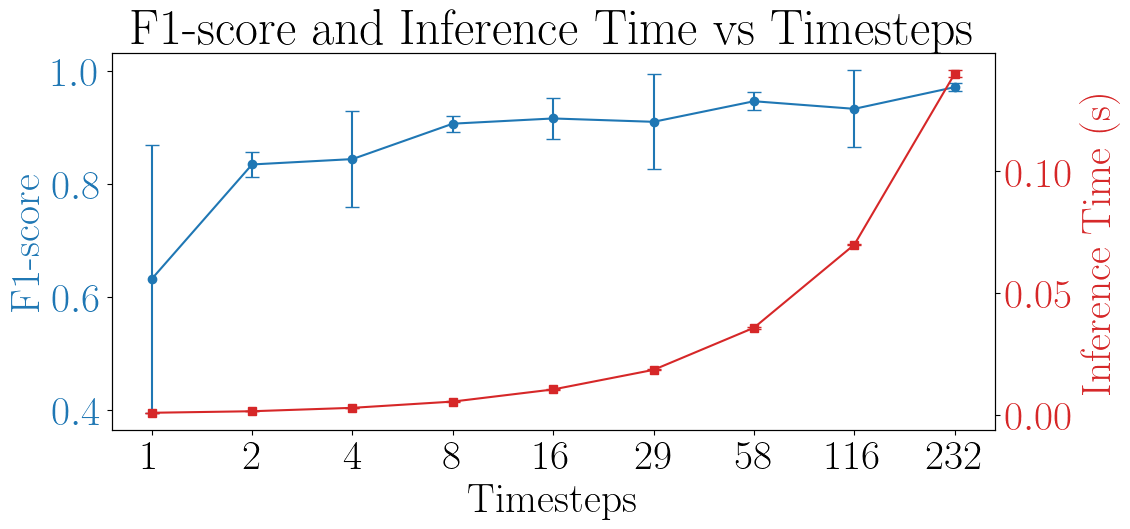

In [15]:
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel("Timesteps")
ax1.set_ylabel("F1-score", color=color)
ax1.errorbar(x_pos, df["f1-avg"], yerr=df["f1-std"], fmt='-o', color=color, capsize=5, label="F1-score")
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticks(x_pos)
ax1.set_xticklabels(x_labels)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel("Inference Time (s)", color=color)
ax2.errorbar(x_pos, df["inference-avg"], yerr=df["inference-std"], fmt='-s', color=color, capsize=5, label="Inference Time")
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_xticks(x_pos)
ax2.set_xticklabels(x_labels)

plt.title("F1-score and Inference Time vs Timesteps")
plt.tight_layout()
plt.show()

### Number of MACCs and ACCs

#### 1. SCAE

In [37]:
path = "./models/scae_snn_1.pt" 
checkpoint = torch.load(path, map_location=device)

autoencoder = network.scae(channels = 64, 
                           kernel_size = (1,1,3),
                           stride = 1, 
                           timesteps = 1,
                           beta = 0.9, 
                           threshold = 0.8, 
                           learn_beta = True, 
                           learn_threshold = True, 
                           surr_grad = surrogate.atan()
                           )

snn =  network.snn_1(input_shape = INP_SHAPE, 
                     hidden = [64,128], 
                     timesteps = 29,
                     kernel = (1,1,4),
                     stride = (1,2,2),
                     beta = 0.9,
                     threshold = 0.8,
                     learn_thr = True, 
                     learn_beta = True,
                     surr_grad = surrogate.atan()
                     )

scae = SCAE(autoencoder, snn).to(device)
scae.load_state_dict(checkpoint['model_state_dict'])
scae.eval()

SCAE(
  (autoencoder): scae(
    (enc_conv1): Conv3d(2, 64, kernel_size=(1, 1, 3), stride=(1, 1, 1), padding=same)
    (enc_bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc_lif1): Leaky()
    (enc_conv2): Conv3d(64, 2, kernel_size=(1, 1, 3), stride=(1, 1, 1), padding=same)
    (enc_bn2): BatchNorm3d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc_lif2): Leaky()
    (dec_conv1): ConvTranspose3d(2, 64, kernel_size=(1, 1, 3), stride=(1, 1, 1), padding=(0, 0, 1))
    (dec_bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dec_lif1): Leaky()
    (dec_conv2): ConvTranspose3d(64, 2, kernel_size=(1, 1, 3), stride=(1, 1, 1), padding=(0, 0, 1))
    (dec_bn2): BatchNorm3d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (sigmoid): Sigmoid()
  )
  (snn): snn_1(
    (avg_pool): AvgPool3d(kernel_size=(1, 1, 4), stride=(1, 2, 2), padding=0)
    (fc_in): Linear(in_fea

In [59]:
flops, macs, params = calflops.calculate_flops(model=scae, 
                                      input_shape=(1, *INP_SHAPE),
                                      output_as_string=True,
                                      )
print("Model FLOPs:%s   MACs:%s   Params:%s \n" %(flops, macs, params))


------------------------------------- Calculate Flops Results -------------------------------------
Notations:
number of parameters (Params), number of multiply-accumulate operations(MACs),
number of floating-point operations (FLOPs), floating-point operations per second (FLOPS),
fwd FLOPs (model forward propagation FLOPs), bwd FLOPs (model backward propagation FLOPs),
default model backpropagation takes 2.00 times as much computation as forward propagation.

Total Training Params:                                                  28.44 K 
fwd MACs:                                                               236.71 MMACs
fwd FLOPs:                                                              532.51 MFLOPS
fwd+bwd MACs:                                                           710.12 MMACs
fwd+bwd FLOPs:                                                          1.6 GFLOPS

-------------------------------- Detailed Calculated FLOPs Results --------------------------------
Each module ca

#### 2. CAE

In [41]:
path = "./models/cae_2_snn_1.pt" 
checkpoint = torch.load(path, map_location=device)

autoencoder = network.cae_2(tau = 0.4, 
                           channels = 64, 
                           kernel_size = (1,1,3), 
                           stride = 1, 
                           )

snn =  network.snn_1(input_shape = INP_SHAPE, 
                     hidden = [64,128], 
                     timesteps = 29,
                     kernel = (1,1,4),
                     stride = (1,2,2),
                     beta = 0.9,
                     threshold = 0.8,
                     learn_thr = True, 
                     learn_beta = True,
                     surr_grad = surrogate.atan()
                     )
    
cae = CAE(autoencoder, snn).to(device)
cae.load_state_dict(checkpoint['model_state_dict'])
cae.eval()

CAE(
  (autoencoder): cae_2(
    (encoder): Sequential(
      (0): Conv3d(2, 64, kernel_size=(1, 1, 3), stride=(1, 1, 1), padding=same)
      (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv3d(64, 2, kernel_size=(1, 1, 3), stride=(1, 1, 1), padding=same)
      (4): BatchNorm3d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): HeavisideCustom()
    )
    (decoder): Sequential(
      (0): ConvTranspose3d(2, 64, kernel_size=(1, 1, 3), stride=(1, 1, 1), padding=(0, 0, 1))
      (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): ConvTranspose3d(64, 2, kernel_size=(1, 1, 3), stride=(1, 1, 1), padding=(0, 0, 1))
      (4): BatchNorm3d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): Sigmoid()
    )
  )
  (snn): snn_1(
    (avg_pool): AvgPool3d(kernel_size=(1, 1, 4), stride=(1, 2, 2), padding=0)
    (fc_in)

In [58]:
flops, macs, params = calflops.calculate_flops(model=cae, 
                                      input_shape=(1, *INP_SHAPE),
                                      output_as_string=True,
                                      )
print("Model FLOPs:%s   MACs:%s   Params:%s \n" %(flops, macs, params))


------------------------------------- Calculate Flops Results -------------------------------------
Notations:
number of parameters (Params), number of multiply-accumulate operations(MACs),
number of floating-point operations (FLOPs), floating-point operations per second (FLOPS),
fwd FLOPs (model forward propagation FLOPs), bwd FLOPs (model backward propagation FLOPs),
default model backpropagation takes 2.00 times as much computation as forward propagation.

Total Training Params:                                                  28.44 K 
fwd MACs:                                                               236.71 MMACs
fwd FLOPs:                                                              551.51 MFLOPS
fwd+bwd MACs:                                                           710.12 MMACs
fwd+bwd FLOPs:                                                          1.65 GFLOPS

-------------------------------- Detailed Calculated FLOPs Results --------------------------------
Each module c

#### 3. SNN

In [45]:
path = "./models/delta_snn_1.pt" 
checkpoint = torch.load(path, map_location=device)

classifier =  network.snn_1(input_shape = INP_SHAPE, 
                     hidden = [64,128], 
                     timesteps = 29,
                     kernel = (1,1,4),
                     stride = (1,2,2),
                     beta = 0.9,
                     threshold = 0.8,
                     learn_thr = True, 
                     learn_beta = True,
                     surr_grad = surrogate.atan()
                     )

delta = SNN_CLSFF(classifier).to(device)
delta.load_state_dict(checkpoint['model_state_dict'])
delta.eval()

SNN_CLSFF(
  (snn): snn_1(
    (avg_pool): AvgPool3d(kernel_size=(1, 1, 4), stride=(1, 2, 2), padding=0)
    (fc_in): Linear(in_features=155, out_features=64, bias=True)
    (lif_in): Leaky()
    (fc_hidden): Linear(in_features=64, out_features=128, bias=True)
    (lif_hidden): Leaky()
    (fc_out): Linear(in_features=2048, out_features=4, bias=True)
    (li_out): Leaky()
  )
)

In [57]:
flops, macs, params = calflops.calculate_flops(model=delta, 
                                      input_shape=(1, *INP_SHAPE),
                                      output_as_string=True,
                                      )
print("Model FLOPs:%s   MACs:%s   Params:%s \n" %(flops, macs, params))


------------------------------------- Calculate Flops Results -------------------------------------
Notations:
number of parameters (Params), number of multiply-accumulate operations(MACs),
number of floating-point operations (FLOPs), floating-point operations per second (FLOPS),
fwd FLOPs (model forward propagation FLOPs), bwd FLOPs (model backward propagation FLOPs),
default model backpropagation takes 2.00 times as much computation as forward propagation.

Total Training Params:                                                  26.5 K  
fwd MACs:                                                               8.64 MMACs
fwd FLOPs:                                                              17.58 MFLOPS
fwd+bwd MACs:                                                           25.92 MMACs
fwd+bwd FLOPs:                                                          52.74 MFLOPS

-------------------------------- Detailed Calculated FLOPs Results --------------------------------
Each module cacu

#### 4. Direct-SNN (Linear)

In [49]:
path = "./models/direct_snn_2.pt" 
checkpoint = torch.load(path, map_location=device)

classifier =  network.snn_2(input_shape = INP_SHAPE, 
                            hidden = [64,128,256],
                            timesteps = 29,
                            kernel = (1,1,4),
                            stride = (1,2,2),
                            beta = 0.9,
                            threshold = 0.8,
                            learn_thr = True, 
                            learn_beta = True,
                            surr_grad = surrogate.atan()
                            )

snn_lin = SNN_CLSFF(classifier).to(device)
snn_lin.load_state_dict(checkpoint['model_state_dict'])
snn_lin.eval()

SNN_CLSFF(
  (snn): snn_2(
    (avg_pool): AvgPool3d(kernel_size=(1, 1, 4), stride=(1, 2, 2), padding=0)
    (fc_in): Linear(in_features=155, out_features=64, bias=True)
    (lif_in): Leaky()
    (fc_hidden1): Linear(in_features=64, out_features=128, bias=True)
    (lif_hidden1): Leaky()
    (fc_hidden2): Linear(in_features=128, out_features=256, bias=True)
    (lif_hidden2): Leaky()
    (fc_out): Linear(in_features=4096, out_features=4, bias=True)
    (lif_out): Leaky()
  )
)

In [50]:
flops, macs, params = calflops.calculate_flops(model=snn_lin, 
                                      input_shape=(1, *INP_SHAPE),
                                      output_as_string=True,
                                      )
print("Model FLOPs:%s   MACs:%s   Params:%s \n" %(flops, macs, params))


------------------------------------- Calculate Flops Results -------------------------------------
Notations:
number of parameters (Params), number of multiply-accumulate operations(MACs),
number of floating-point operations (FLOPs), floating-point operations per second (FLOPS),
fwd FLOPs (model forward propagation FLOPs), bwd FLOPs (model backward propagation FLOPs),
default model backpropagation takes 2.00 times as much computation as forward propagation.

Total Training Params:                                                  67.72 K 
fwd MACs:                                                               24.08 MMACs
fwd FLOPs:                                                              48.46 MFLOPS
fwd+bwd MACs:                                                           72.25 MMACs
fwd+bwd FLOPs:                                                          145.39 MFLOPS

-------------------------------- Detailed Calculated FLOPs Results --------------------------------
Each module ca

#### 5. Direct-SNN (Conv)

In [51]:
path = "./models/direct_snn_conv_2.pt" 
checkpoint = torch.load(path, map_location=device)

classifier =  network.snn_conv2(input_shape = INP_SHAPE, 
                            channels = [64, 128],
                            timesteps = 29,
                            kernel = (1,1,3),
                            stride = (1,1,1),
                            beta = 0.9,
                            threshold = 0.8,
                            learn_thr = True, 
                            learn_beta = True,
                            surr_grad = surrogate.atan()
                            )

snn_conv = SNN_CLSFF(classifier).to(device)
snn_conv.load_state_dict(checkpoint['model_state_dict'])
snn_conv.eval()

SNN_CLSFF(
  (snn): snn_conv2(
    (conv1): Conv3d(2, 64, kernel_size=(1, 1, 3), stride=(1, 1, 1), padding=same)
    (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (lif1): Leaky()
    (conv2): Conv3d(64, 128, kernel_size=(1, 1, 3), stride=(1, 1, 1), padding=same)
    (bn2): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (lif2): Leaky()
    (fc_out): Linear(in_features=655360, out_features=4, bias=True)
    (lif_out): Leaky()
  )
)

In [53]:
flops, macs, params = calflops.calculate_flops(model=snn_conv, 
                                      input_shape=(1, *INP_SHAPE),
                                      output_as_string=True,
                                      )
print("Model FLOPs:%s   MACs:%s   Params:%s \n" %(flops, macs, params))


------------------------------------- Calculate Flops Results -------------------------------------
Notations:
number of parameters (Params), number of multiply-accumulate operations(MACs),
number of floating-point operations (FLOPs), floating-point operations per second (FLOPS),
fwd FLOPs (model forward propagation FLOPs), bwd FLOPs (model backward propagation FLOPs),
default model backpropagation takes 2.00 times as much computation as forward propagation.

Total Training Params:                                                  2.65 M  
fwd MACs:                                                               3.78 GMACs
fwd FLOPs:                                                              7.65 GFLOPS
fwd+bwd MACs:                                                           11.35 GMACs
fwd+bwd FLOPs:                                                          22.95 GFLOPS

-------------------------------- Detailed Calculated FLOPs Results --------------------------------
Each module cacul

#### 6. DISC cnn

In [55]:
path = "./models/disc_cnn.pt" 
checkpoint = torch.load(path, map_location=device)

classifier =  network.cnn_disc()

disc = SNN_CLSFF(classifier).to(device)
disc.load_state_dict(checkpoint['model_state_dict'])
disc.eval()

SNN_CLSFF(
  (snn): cnn_disc(
    (conv_layers): Sequential(
      (0): Conv3d(2, 8, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      (1): ReLU()
      (2): Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      (3): ReLU()
      (4): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      (5): ReLU()
      (6): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      (7): ReLU()
      (8): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      (9): ReLU()
      (10): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      (11): ReLU()
    )
    (dropout): Dropout(p=0.2, inplace=False)
    (dense1): Linear(in_features=512, out_features=64, bias=True)
    (dense2): Linear(in_features=64, out_features=4, bias=True)
  )
)

In [56]:
flops, macs, params = calflops.calculate_flops(model=disc, 
                                      input_shape=(1, *INP_SHAPE),
                                      output_as_string=True,
                                      )
print("Model FLOPs:%s   MACs:%s   Params:%s \n" %(flops, macs, params))


------------------------------------- Calculate Flops Results -------------------------------------
Notations:
number of parameters (Params), number of multiply-accumulate operations(MACs),
number of floating-point operations (FLOPs), floating-point operations per second (FLOPS),
fwd FLOPs (model forward propagation FLOPs), bwd FLOPs (model backward propagation FLOPs),
default model backpropagation takes 2.00 times as much computation as forward propagation.

Total Training Params:                                                  770.03 K
fwd MACs:                                                               32.71 MMACs
fwd FLOPs:                                                              65.85 MFLOPS
fwd+bwd MACs:                                                           98.14 MMACs
fwd+bwd FLOPs:                                                          197.56 MFLOPS

-------------------------------- Detailed Calculated FLOPs Results --------------------------------
Each module ca

### Run the networks 5 times

In [10]:
seeds = [1, 22, 307, 5899, 75431]
surr_fn = surrogate.atan()
accuracies, f1_scores = [], []
precisions, recalls = [], []

for seed in seeds:
    torch.manual_seed(seed) 

    autoencoder = network.scae(channels = 64, 
                            kernel_size = (1,1,3),
                            stride = 1, 
                            timesteps = 1,
                            beta = 0.9, 
                            threshold = 0.8, 
                            learn_beta = True, 
                            learn_threshold = True, 
                            surr_grad = surr_fn
                            )

    snn =  network.snn_1(input_shape = INP_SHAPE, 
                        hidden = [64,128], 
                        timesteps = 29,
                        kernel = (1,1,4),
                        stride = (1,2,2),
                        beta = 0.9,
                        threshold = 0.8,
                        learn_thr = True, 
                        learn_beta = True,
                        surr_grad = surr_fn
                        )

    net = SCAE(autoencoder, snn).to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr = 1e-3)

    trainer = Trainer(
                    model = net,
                    optimizer = optimizer,
                    device = device,
                    acc_steps = 1,
                    patience = 20,
                    model_path = None
            )

    trainer.fit(
                    train_loader = train_loader,
                    val_loader = val_loader,
                    epochs = 50
            )
    
    acc, prec, rec, f1, confusion_mx = trainer.classification_metrics(
                                dataloader=test_loader,
                                avg_type="macro",  
                                verbose=False)
    
    accuracies.append(acc)
    precisions.append(prec)
    recalls.append(rec)
    f1_scores.append(f1)

accuracies = np.array(accuracies)
precisions = np.array(precisions)
recalls = np.array(recalls)
f1_scores = np.array(f1_scores)

print("-----------------------------------------------\n")
print(f"Accuracy:  mean={accuracies.mean():.4f}, std={accuracies.std():.4f}")
print(f"Precision: mean={precisions.mean():.4f}, std={precisions.std():.4f}")
print(f"Recall:    mean={recalls.mean():.4f}, std={recalls.std():.4f}")
print(f"F1-score:  mean={f1_scores.mean():.4f}, std={f1_scores.std():.4f}")

Epoch 1 - train_loss: 0.3707 | train_acc: 0.7516 | val_loss: 0.3574 | val_acc: 0.7449
Epoch 6 - train_loss: 0.1231 | train_acc: 0.9453 | val_loss: 0.1839 | val_acc: 0.9012
Epoch 11 - train_loss: 0.0904 | train_acc: 0.9673 | val_loss: 0.3652 | val_acc: 0.7759
Epoch 16 - train_loss: 0.0774 | train_acc: 0.9762 | val_loss: 0.1919 | val_acc: 0.8966
Epoch 21 - train_loss: 0.0612 | train_acc: 0.9857 | val_loss: 0.1619 | val_acc: 0.9354
Epoch 26 - train_loss: 0.0519 | train_acc: 0.9940 | val_loss: 0.2911 | val_acc: 0.8862
Epoch 31 - train_loss: 0.0775 | train_acc: 0.9715 | val_loss: 0.2244 | val_acc: 0.8659
Epoch 36 - train_loss: 0.0495 | train_acc: 0.9958 | val_loss: 0.1895 | val_acc: 0.9054
Early stopping at epoch 40
AVERAGE TYPE: macro

Accuracy: 0.8956
Precision: 0.8816
Recall: 0.9155              
F1 score: 0.8943
Epoch 1 - train_loss: 0.3487 | train_acc: 0.7218 | val_loss: 0.4449 | val_acc: 0.7472
Epoch 6 - train_loss: 0.1434 | train_acc: 0.9416 | val_loss: 0.1465 | val_acc: 0.9215
Epoch

In [8]:
seeds = [1, 22, 307, 5899, 75431]
surr_fn = surrogate.atan()
accuracies, f1_scores = [], []
precisions, recalls = [], []

for seed in seeds:
    torch.manual_seed(seed) 

    autoencoder = network.cae_2(tau = 0.4, 
                           channels = 64, 
                           kernel_size = (1,1,3), 
                           stride = 1, 
                           )
    
    snn =  network.snn_1(input_shape = INP_SHAPE, 
                        hidden = [64,128], 
                        timesteps = 29,
                        kernel = (1,1,4),
                        stride = (1,2,2),
                        beta = 0.9,
                        threshold = 0.8,
                        learn_thr = True, 
                        learn_beta = True,
                        surr_grad = surrogate.atan()
                        )
    
    net = CAE(autoencoder, snn).to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr = 1e-3)

    trainer = Trainer(
                    model = net,
                    optimizer = optimizer,
                    device = device,
                    acc_steps = 1,
                    patience = 20,
                    model_path = None
            )

    trainer.fit(
                    train_loader = train_loader,
                    val_loader = val_loader,
                    epochs = 50
            )
    
    acc, prec, rec, f1, confusion_mx = trainer.classification_metrics(
                                dataloader=test_loader,
                                avg_type="macro",  
                                verbose=False)
    
    accuracies.append(acc)
    precisions.append(prec)
    recalls.append(rec)
    f1_scores.append(f1)

accuracies = np.array(accuracies)
precisions = np.array(precisions)
recalls = np.array(recalls)
f1_scores = np.array(f1_scores)

print("-----------------------------------------------\n")
print(f"Accuracy:  mean={accuracies.mean():.4f}, std={accuracies.std():.4f}")
print(f"Precision: mean={precisions.mean():.4f}, std={precisions.std():.4f}")
print(f"Recall:    mean={recalls.mean():.4f}, std={recalls.std():.4f}")
print(f"F1-score:  mean={f1_scores.mean():.4f}, std={f1_scores.std():.4f}")

Epoch 1 - train_loss: 0.3736 | train_acc: 0.7409 | val_loss: 0.3494 | val_acc: 0.7858
Epoch 6 - train_loss: 0.1424 | train_acc: 0.9381 | val_loss: 0.1249 | val_acc: 0.9557
Epoch 11 - train_loss: 0.1030 | train_acc: 0.9661 | val_loss: 0.2947 | val_acc: 0.8224
Epoch 16 - train_loss: 0.0850 | train_acc: 0.9756 | val_loss: 0.1153 | val_acc: 0.9490
Epoch 21 - train_loss: 0.1225 | train_acc: 0.9631 | val_loss: 0.1062 | val_acc: 0.9636
Epoch 26 - train_loss: 0.0697 | train_acc: 0.9851 | val_loss: 0.1473 | val_acc: 0.9213
Epoch 31 - train_loss: 0.0539 | train_acc: 0.9929 | val_loss: 0.1051 | val_acc: 0.9493
Epoch 36 - train_loss: 0.0575 | train_acc: 0.9869 | val_loss: 0.4104 | val_acc: 0.8036
Epoch 41 - train_loss: 0.0409 | train_acc: 0.9958 | val_loss: 0.1062 | val_acc: 0.9783
Epoch 46 - train_loss: 0.0470 | train_acc: 0.9929 | val_loss: 0.0708 | val_acc: 0.9857
AVERAGE TYPE: macro

Accuracy: 0.9451
Precision: 0.9378
Recall: 0.9457              
F1 score: 0.9392
Epoch 1 - train_loss: 0.3086 |